# __ML Unige 2023: Advertisement Impact Prediction__
## Predicting customer subscriptions from an advertisement campaign
### Liam Phan, Michael Bigler and Manuela Giansante

***

# __Goal__

A company wants to assess the quality of their online advertisement campaign. Online users are the main interest in this campaign. The users see a web banner during their browsing activity. For each user, they want to be able to predict whether they subscribe to the advertised product through the advertisement banner, based on the information they have about them. To subscribe, the user has to click on the banner and then subscribe to the service.

The target variable name is __subscription__.

# __Packages__

In [419]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from facets_overview.generic_feature_statistics_generator import GenericFeatureStatisticsGenerator
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns
import matplotlib as mpl
import matplotlib.colors as mcolors

In [454]:
import pandas as pd
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns
import numpy as np
import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer, IterativeImputer, SimpleImputer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import KFold
from sklearn.linear_model import RidgeClassifier, Lasso
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [465]:
# Color palette
main_col = "#274156"
second_col = "#A2A77F"
target_col = "#499167"

# __Data__

__File descriptions__

***

MLUnige2023_subscriptions_train.csv - The training set (features + response).

MLUnige2023_subscriptions_test.csv - The test set (features only).

MLUnige2023_sampleSubmission.csv - A sample submission file in the correct format (with random predictions).

<br>

__Data fields__

***

__Unique identifier__

1. __Id__: a unique identifier of the observations in each dataset. In the test set, it is used to match your predictions with the true values.

<br>

__Target variable (only in the training data)__

2. __subscription__: whether the user subscribed through the banner (1:yes, 0:no)

<br>

__Demographic variables__

3. __age__: (numeric)

4. __job__: type of job (categorical: teacher, industrial_worker, entrepreneur, housekeeper, manager, retired, freelance, salesman, student, technology, unemployed, na)

5. __marital__: marital status (categorical: married, divorced, single)

6. __education__: (categorical: high_school, university, grad_school, na)

<br>

__Variables about the current campaign__

7. __device__: from which device does the user see the banner? (categorical: smartphone, desktop, na)

8. __day__: last day of the month when the user saw the banner (numeric)

9. __month__: last month of the year when the user saw the banner (numeric)

10. __time_spent__: how long the user looked at the banner last time (in seconds) (numeric)

11. __banner_views__: number of times the user saw the banner (numeric)

<br>

__Variables about an old campaign for the same product__

12. __banner_views_old__: number of times the user saw the banner during an old (and related) online ads campaign (numeric)

13. __days_elapsed_old__: number of days since the user saw the banner of an old (and related) online ads campaign (numeric, -1 if the user never saw the banner)

14. __outcome_old__: outcome of the old (and related) online ads campaign (categorical: failure, other, success, na)

<br>

__Variables with no name__

15. __X1__: (categorical: 1, 0)

16. __X2__: (categorical: 1, 0)

17. __X3__: (categorical: 1, 0)

18. __X4__: (numeric)

***

<br>

We first start by loading both __Datasets__

In [231]:
# Train
train =  pd.read_csv('DATA/MLUnige2023_subscriptions_train.csv', index_col='Id', na_values='na', header=0)
train = train.astype({'job':'category', 'marital':'category', 'education':'category', 'device':'category', 'outcome_old':'category', 'X1':'category', 'X2':'category', 'X3':'category', 'X4':'float64', 'subscription':'category', 'day':'category', 'month':'category'})
train.day = pd.Categorical(train.day, ordered=True)
train.month = pd.Categorical(train.month, ordered=True)

train_categorical = list(train.select_dtypes(include=['category']).columns)
train_numeric = list(train.select_dtypes(include=['int64', 'float64']).columns)

train_numeric_target = train_numeric.copy()
train_numeric_target.append("subscription")

# Test
test =  pd.read_csv('DATA/MLUnige2023_subscriptions_test.csv', index_col='Id', na_values='na', header=0)
test = test.astype({'job':'category', 'marital':'category', 'education':'category', 'device':'category', 'outcome_old':'category', 'X1':'category', 'X2':'category', 'X3':'category', 'X4':'float64', 'day':'category', 'month':'category'})
test.day = pd.Categorical(test.day, ordered=True)
test.month = pd.Categorical(test.month, ordered=True)

test_categorical = list(test.select_dtypes(include=['category']).columns)
test_numeric = list(test.select_dtypes(include=['int64', 'float64']).columns)



Here is our __Train__ Dataset:

In [232]:
train

age                job   marital    education      device day month  \
Id                                                                          
0      28          freelance   married  grad_school  smartphone   4     2   
1      48  industrial_worker   married   university  smartphone  30     4   
2      27            teacher   married   university  smartphone  14     7   
3      44         unemployed  divorced   university  smartphone  13     5   
4      29            manager    single  grad_school  smartphone  26     4   
...   ...                ...       ...          ...         ...  ..   ...   
8947   54  industrial_worker   married   university  smartphone  16     7   
8948   43  industrial_worker   married   university  smartphone   4     2   
8949   27            manager    single  grad_school         NaN   5     6   
8950   77            retired  divorced  grad_school  smartphone  14     4   
8951   33         technology    single  grad_school  smartphone   4     5   

      time_spent  banner_views  banner_views_old  days_elapsed_old  \
Id                                                                   
0          26.80             3                 4               196   
1          13.05             1                 1                79   
2           8.10             3                 0                -1   
3           7.10             2                 1               369   
4          15.90             2                 2               143   
...          ...           ...               ...               ...   
8947        7.30             1                 0                -1   
8948       37.75             2                 0                -1   
8949       29.00             3                 0                -1   
8950        7.55             1                 0                -1   
8951       29.10             1                 1                66   

     outcome_old X1 X2 X3        X4 subscription  
Id                                                
0        failure  0  0  1  0.072803            1  
1        success  0  0  0  0.075454            1  
2            NaN  0  1  1  0.068110            0  
3          other  0  0  1  0.091942            0  
4        success  0  0  0  0.085922            1  
...          ... .. .. ..       ...          ...  
8947         NaN  1  0  0  0.072803            0  
8948         NaN  0  0  1  0.081456            1  
8949         NaN  0  0  1  0.079186            1  
8950         NaN  0  0  0  0.115102            1  
8951     success  0  0  1  0.087656            1  

[8952 rows x 17 columns]

In [247]:
print("We have",train.shape[0], "Rows and", train.shape[1],"Columns")

We have 8952 Rows and 17 Columns


Here is our __Test__ Dataset:

In [233]:
test

age                job   marital    education      device day month  \
Id                                                                          
0      53            retired   married   university         NaN  17     6   
1      61            manager   married  grad_school  smartphone  20     4   
2      51  industrial_worker   married   university         NaN   4     7   
3      34            manager   married  grad_school         NaN  28     5   
4      30            manager   married  grad_school  smartphone   4     5   
...   ...                ...       ...          ...         ...  ..   ...   
3832   47  industrial_worker   married          NaN         NaN   5     6   
3833   30            teacher    single   university  smartphone   3     3   
3834   55            teacher   married   university         NaN  26     6   
3835   46            teacher  divorced   university  smartphone  13     2   
3836   53         technology   married   university     desktop  17     4   

      time_spent  banner_views  banner_views_old  days_elapsed_old  \
Id                                                                   
0           5.25             1                 0                -1   
1           9.00             1                 0                -1   
2           9.65             1                 0                -1   
3          13.45             2                 0                -1   
4          16.15             2                 0                -1   
...          ...           ...               ...               ...   
3832       19.20             2                 0                -1   
3833        3.65             1                 0                -1   
3834        5.15             5                 0                -1   
3835        5.55             1                 0                -1   
3836       15.50             3                 1               180   

     outcome_old X1 X2 X3        X4  
Id                                   
0            NaN  0  0  1  0.084570  
1            NaN  0  0  0  0.075227  
2            NaN  0  0  0  0.075781  
3            NaN  0  0  1  0.070043  
4            NaN  0  0  0  0.171618  
...          ... .. .. ..       ...  
3832         NaN  0  0  1  0.104216  
3833         NaN  1  0  0  0.077552  
3834         NaN  0  0  1  0.129156  
3835         NaN  0  0  0  0.093067  
3836     success  0  0  1  0.120949  

[3837 rows x 16 columns]

In [254]:
print("We have",test.shape[0], "Rows and", test.shape[1],"Columns (We don't know the subscription outcome of the test data)")

We have 3837 Rows and 16 Columns (We don't know the subscription outcome of the test data)


# __Exploratory Data Analysis__

## __Duplicates__

We check if there is any perfect __duplicates__ in both our Datasets:

In [255]:
# Train
## check for duplicate rows
duplicates = train.duplicated()

## display the duplicate rows
print("\n",train[duplicates])

# Test
## check for duplicate rows
duplicates = test.duplicated()

## display the duplicate rows
print("\n",test[duplicates])


 Empty DataFrame
Columns: [age, job, marital, education, device, day, month, time_spent, banner_views, banner_views_old, days_elapsed_old, outcome_old, X1, X2, X3, X4, subscription]
Index: []

 Empty DataFrame
Columns: [age, job, marital, education, device, day, month, time_spent, banner_views, banner_views_old, days_elapsed_old, outcome_old, X1, X2, X3, X4]
Index: []


The dataframes __Train__ and __Test__ has no duplicate rows. 

## __Missings__

We then check how many and where are our __missings__ values in both __Train__ and __Test__.

### Train

In [256]:
train.isna().sum()

age                    0
job                   61
marital                0
education            378
device              2050
day                    0
month                  0
time_spent             0
banner_views           0
banner_views_old       0
days_elapsed_old       0
outcome_old         6804
X1                     0
X2                     0
X3                     0
X4                     0
subscription           0
dtype: int64

### Test

In [257]:
test.isna().sum()

age                    0
job                   21
marital                0
education            160
device               901
day                    0
month                  0
time_spent             0
banner_views           0
banner_views_old       0
days_elapsed_old       0
outcome_old         2937
X1                     0
X2                     0
X3                     0
X4                     0
dtype: int64

In both Datasets, we have a lot of __missings__ in __outcome_old__, __device__, __education__ and __job__

We also know that __day_elapsed_old__ is having the same __missings__ as __outcome_old__, just encoded as -1 instead. We can also __visualize__ it with a plot:

### Train

Text(0.5, 1.0, 'Missing Values on Train')

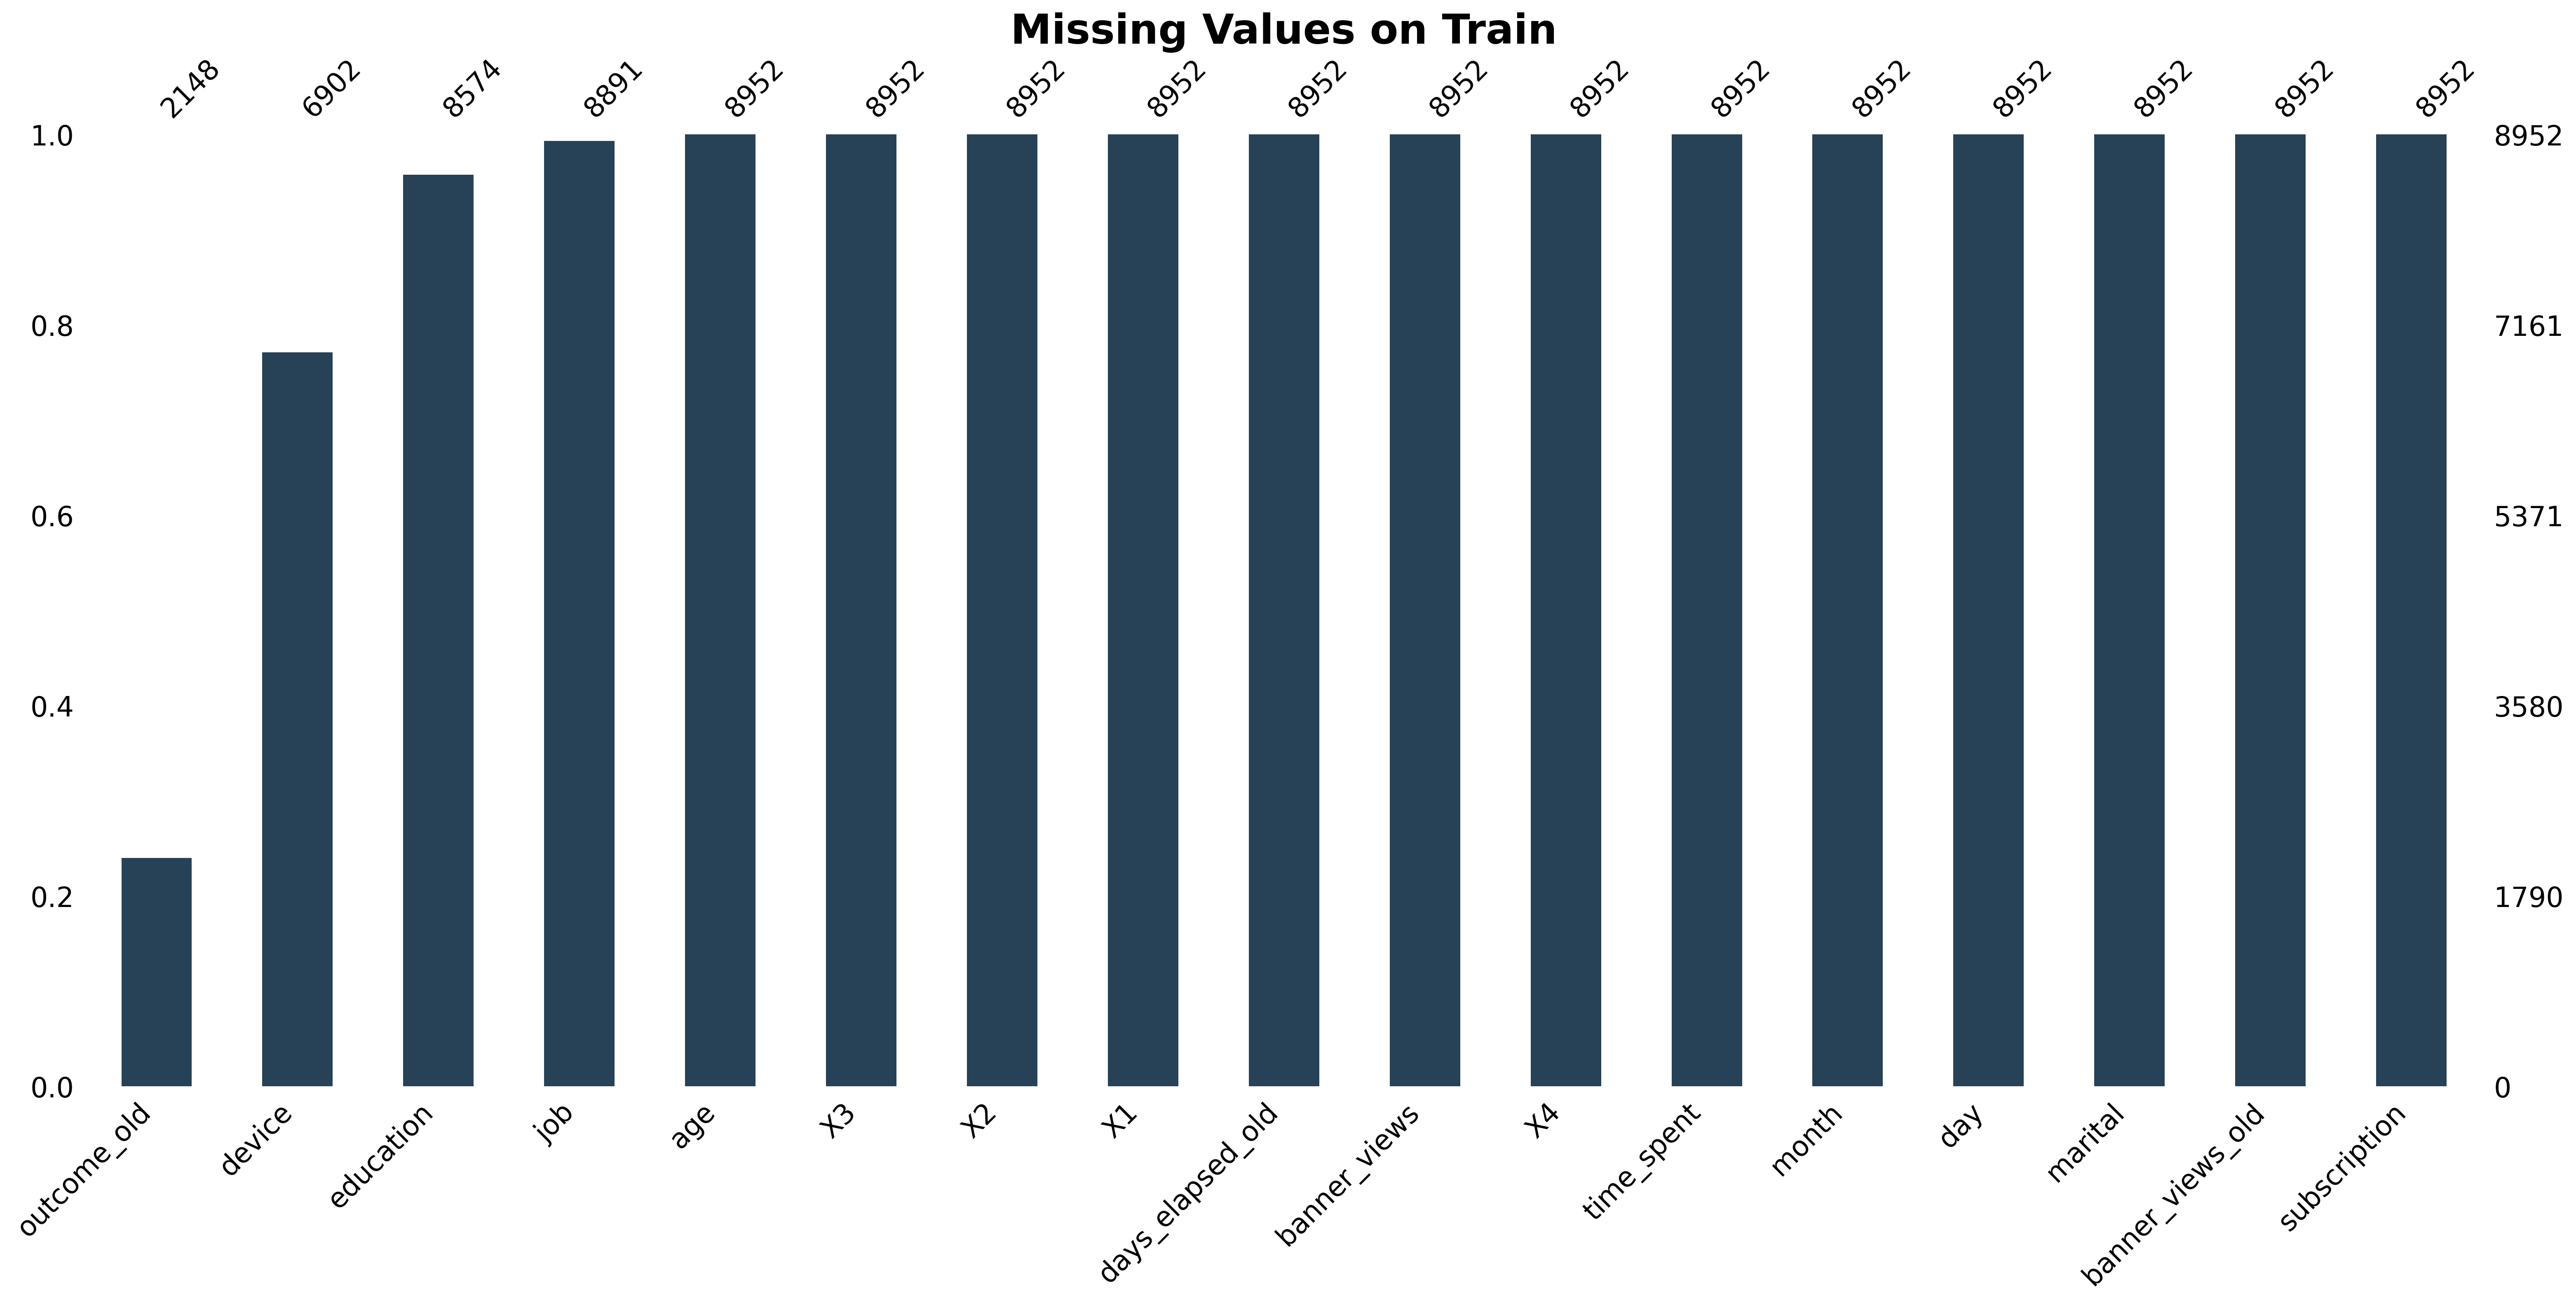

In [315]:
mpl.rcParams['figure.dpi']= 300

msno.bar(train,color=main_col, sort="ascending")
plt.title("Missing Values on Train", fontweight='bold', fontsize=24)

### Test

Text(0.5, 1.0, 'Missing Values on Test')

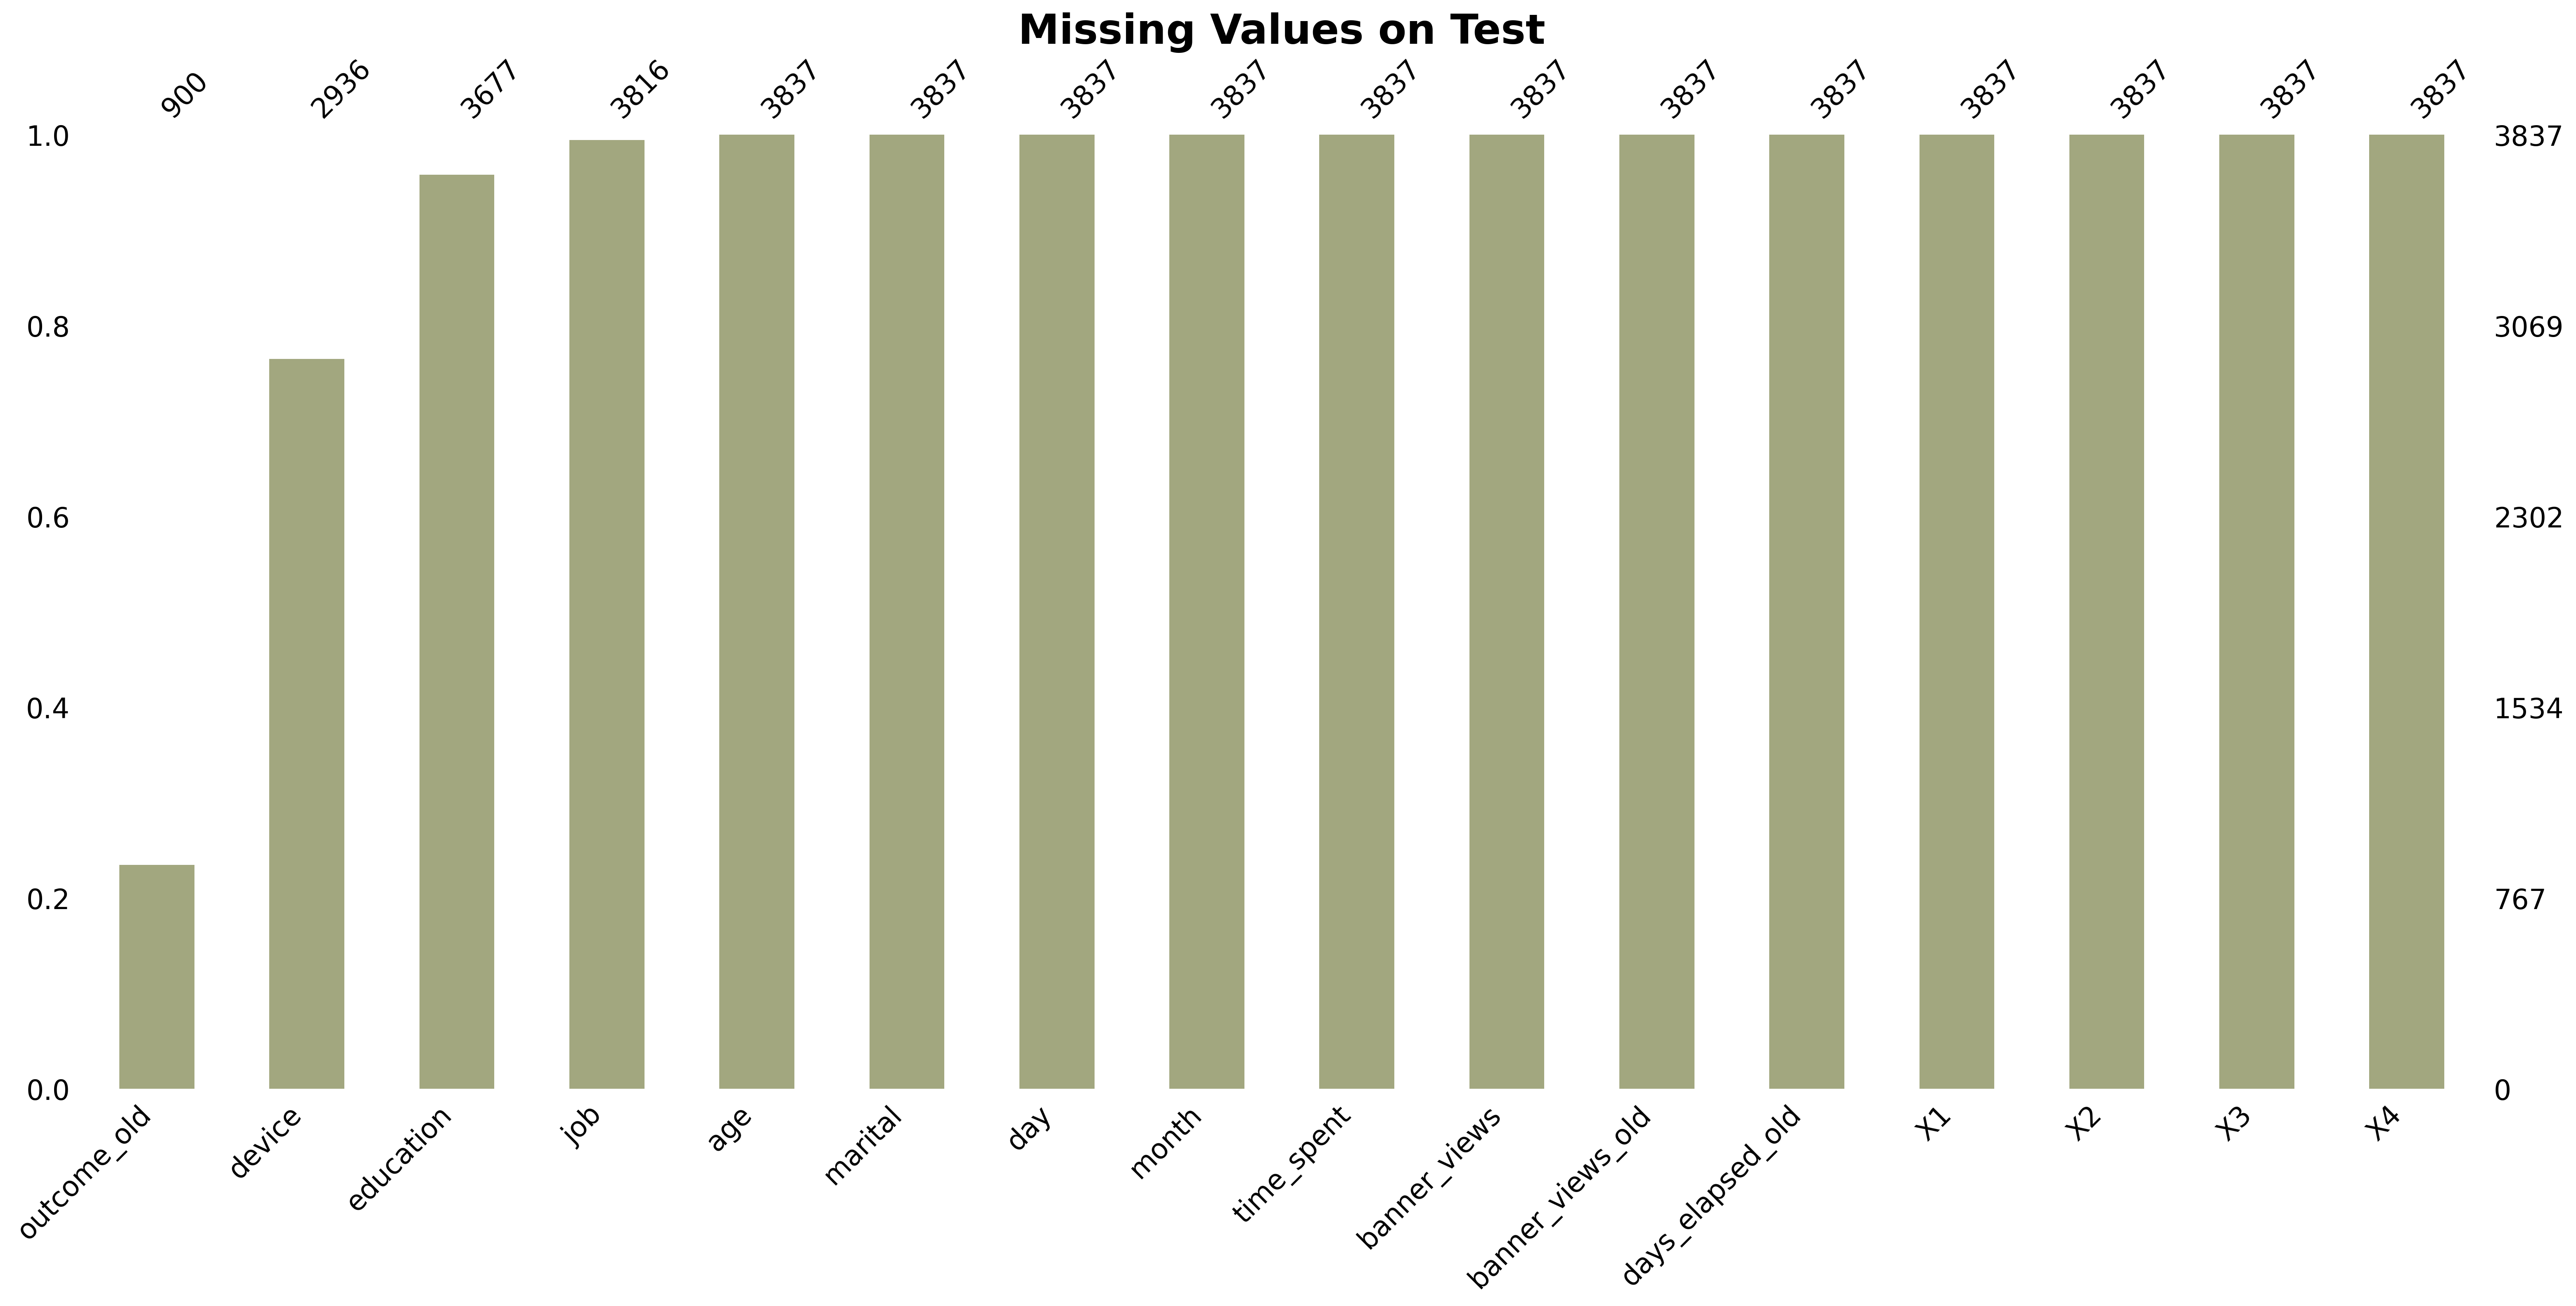

In [316]:
mpl.rcParams['figure.dpi']= 300

msno.bar(test,color=second_col, sort="ascending")
plt.title("Missing Values on Test", fontweight='bold', fontsize=24)

We better see that __outcome_old__ and __device__ are our main missings with __education__ (and __day_elapsed_old__ is -1 but still would count as a theorical missing)

## __Visualization__

### Pairplot

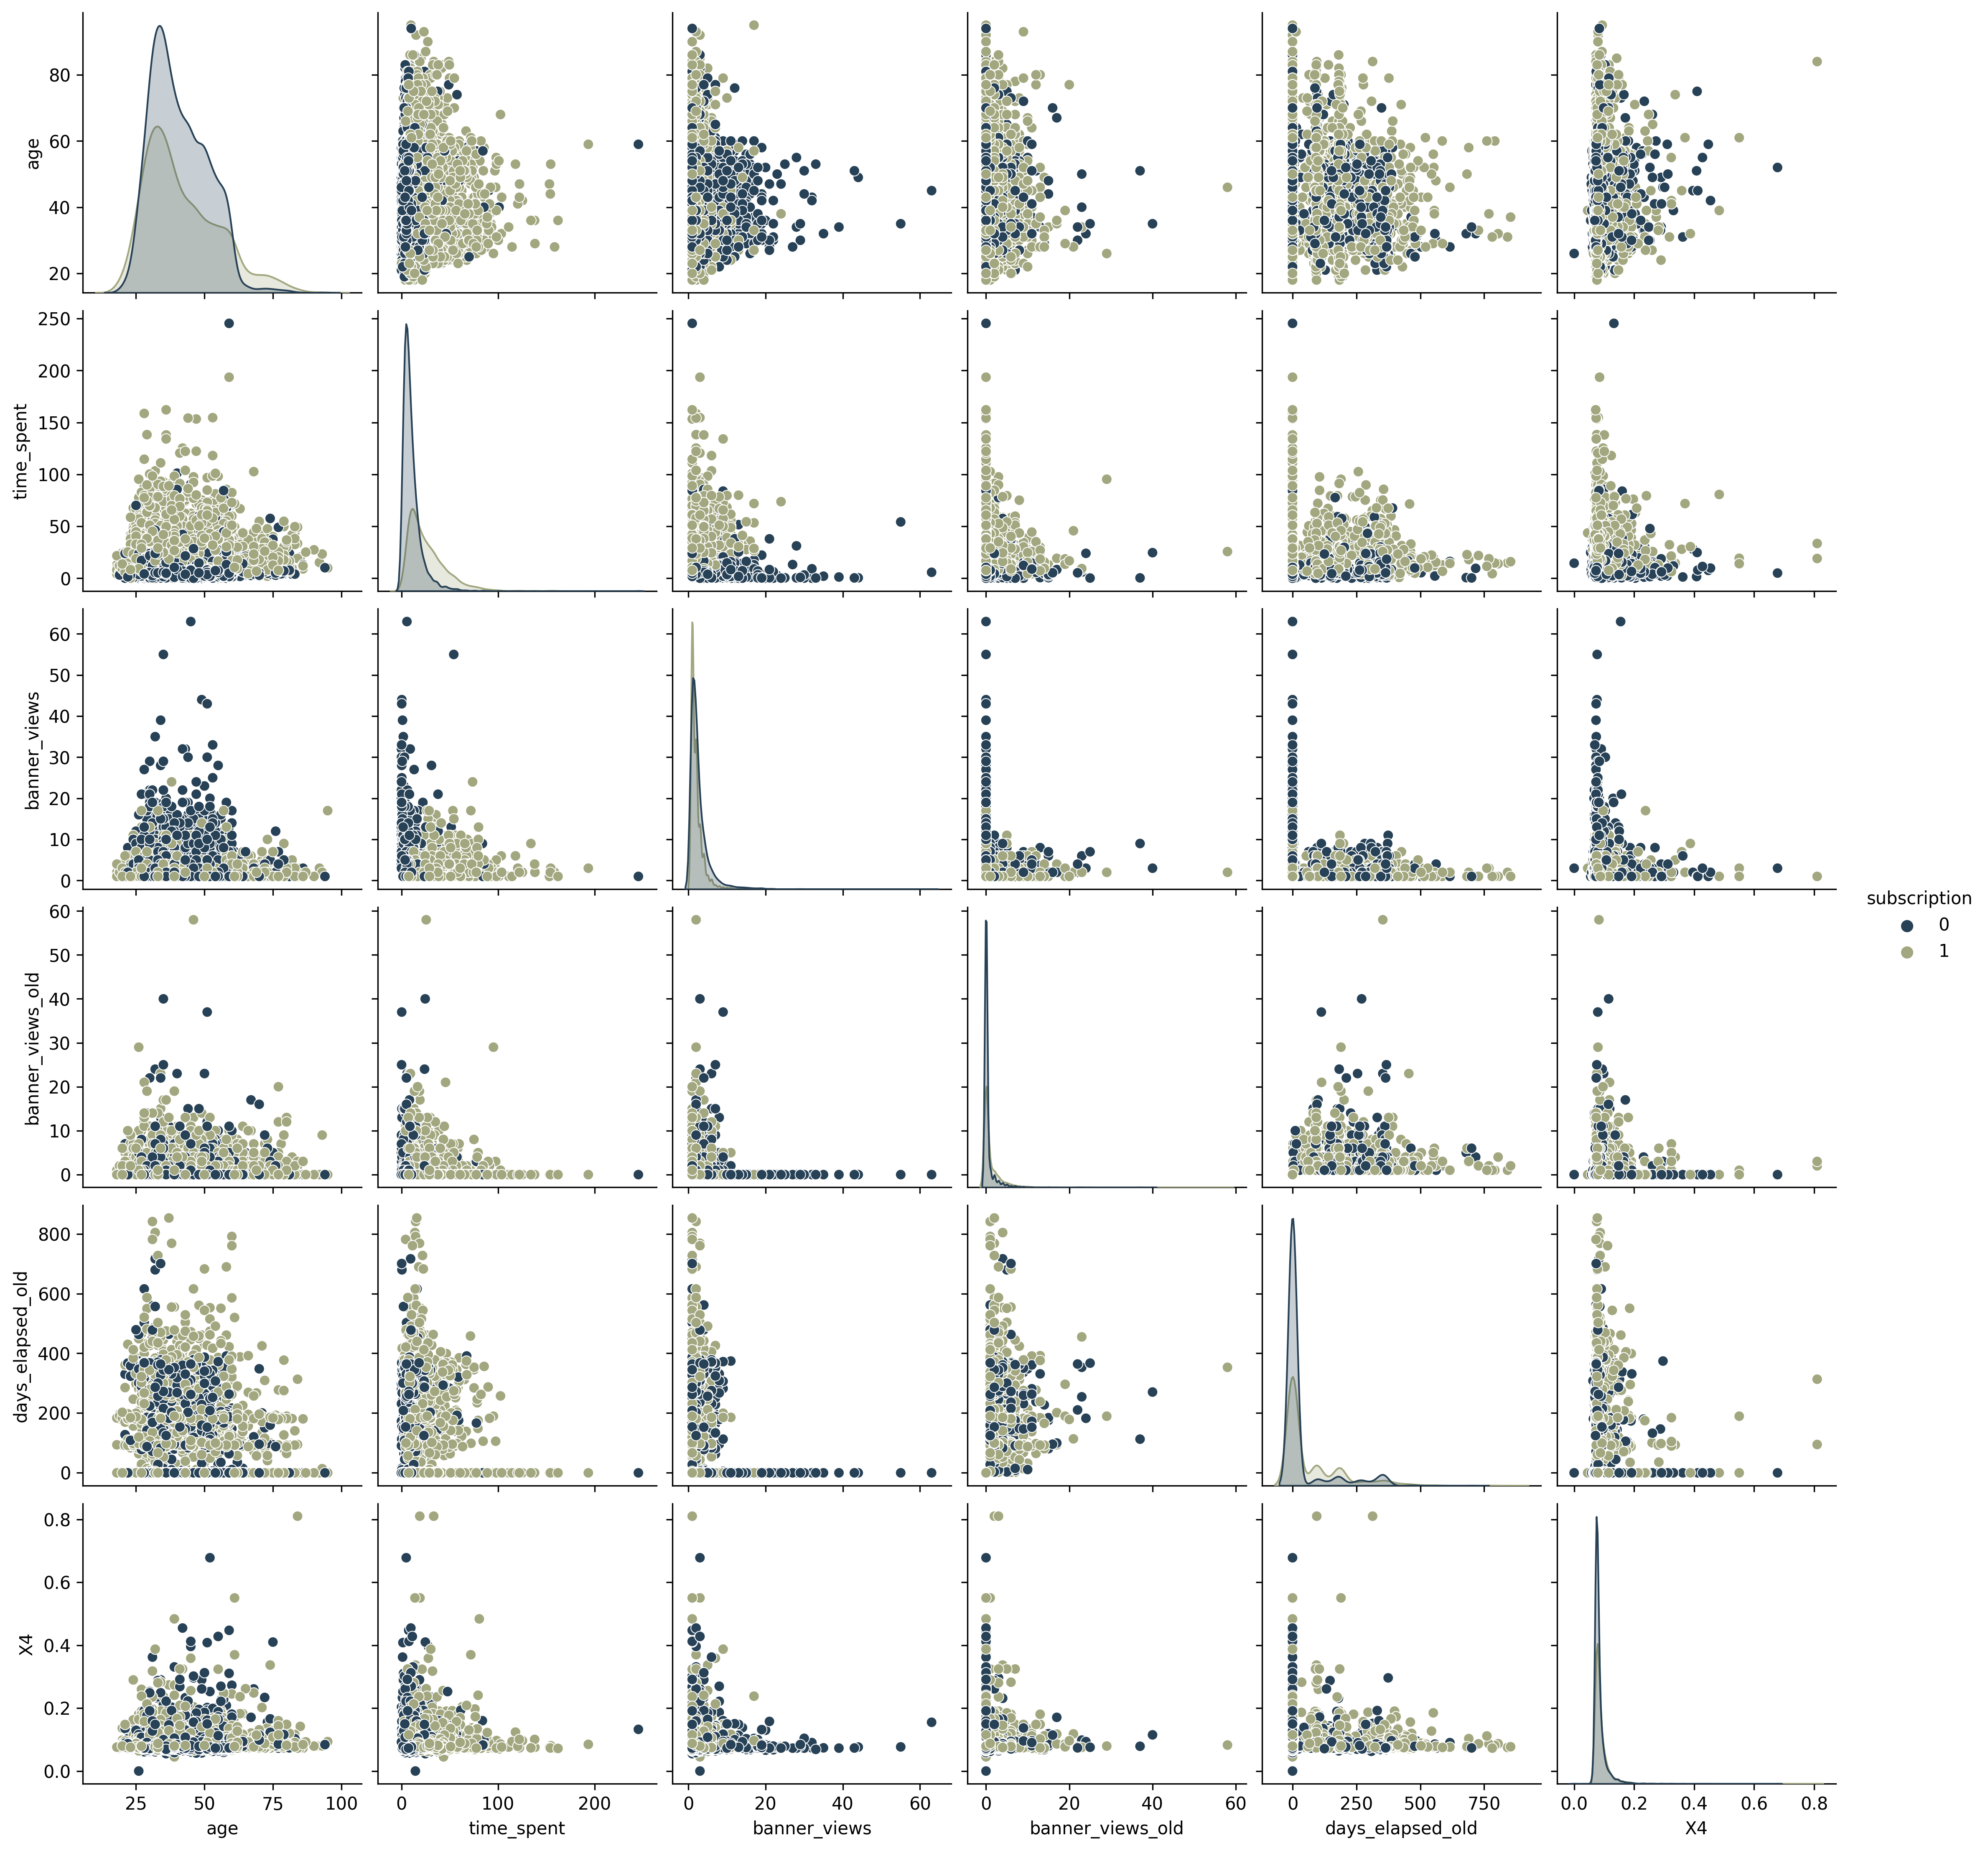

In [317]:
mpl.rcParams['figure.dpi']= 300

colors_subscription = [main_col, second_col]
sns.pairplot(train, hue = "subscription", palette=colors_subscription)

### Barplots

(array([   0., 1000., 2000., 3000., 4000., 5000., 6000.]), [Text(0, 0.0, '0'), Text(0, 1000.0, '1000'), Text(0, 2000.0, '2000'), Text(0, 3000.0, '3000'), Text(0, 4000.0, '4000'), Text(0, 5000.0, '5000'), Text(0, 6000.0, '6000')])

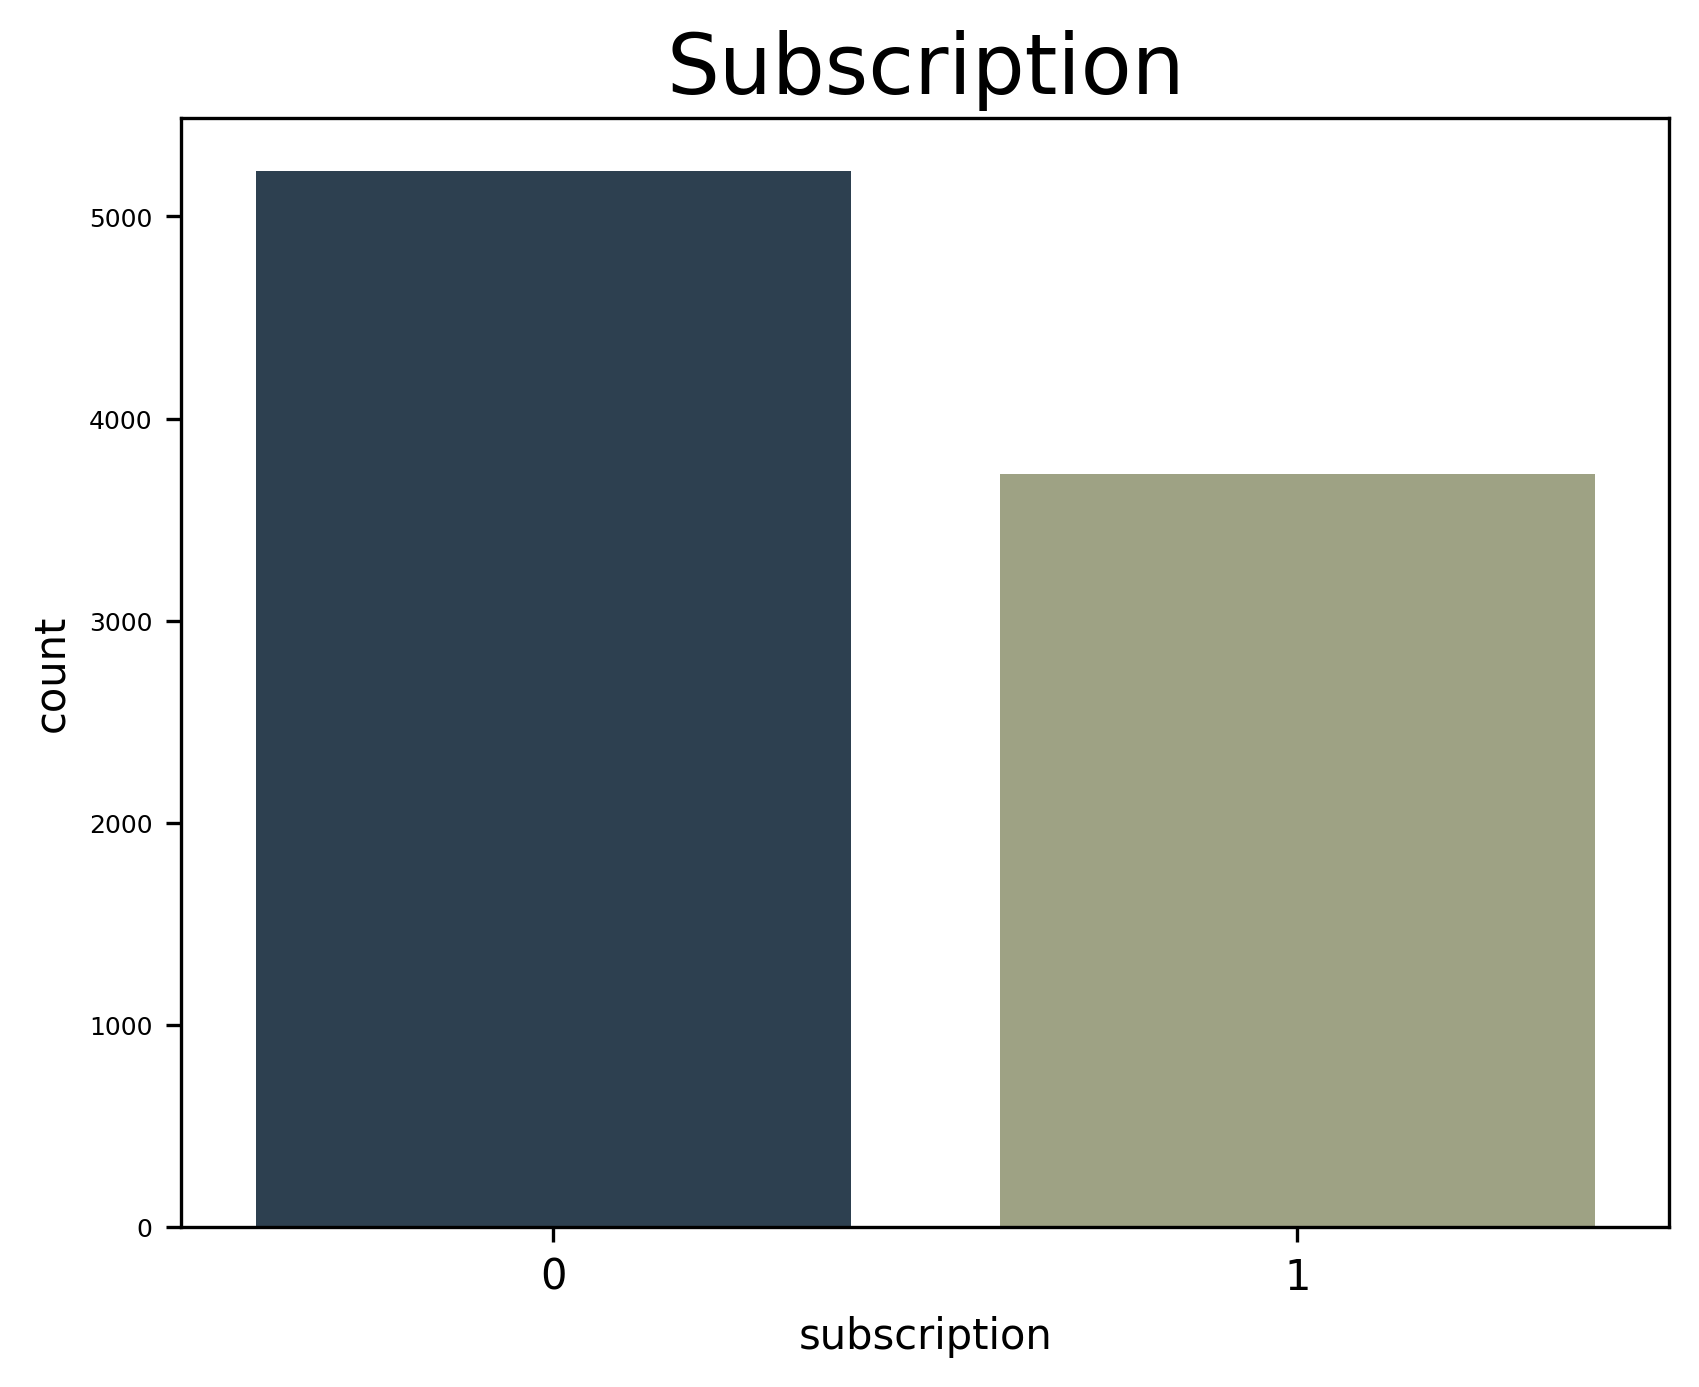

In [408]:
mpl.rcParams['figure.dpi']= 300

sns.countplot(x="subscription", data=train,palette= colors_subscription)

plt.title("Subscription", fontsize=18)
plt.yticks(fontsize=6)


(array([   0.,  200.,  400.,  600.,  800., 1000., 1200., 1400.]), [Text(0, 0.0, '0'), Text(0, 200.0, '200'), Text(0, 400.0, '400'), Text(0, 600.0, '600'), Text(0, 800.0, '800'), Text(0, 1000.0, '1000'), Text(0, 1200.0, '1200'), Text(0, 1400.0, '1400')])

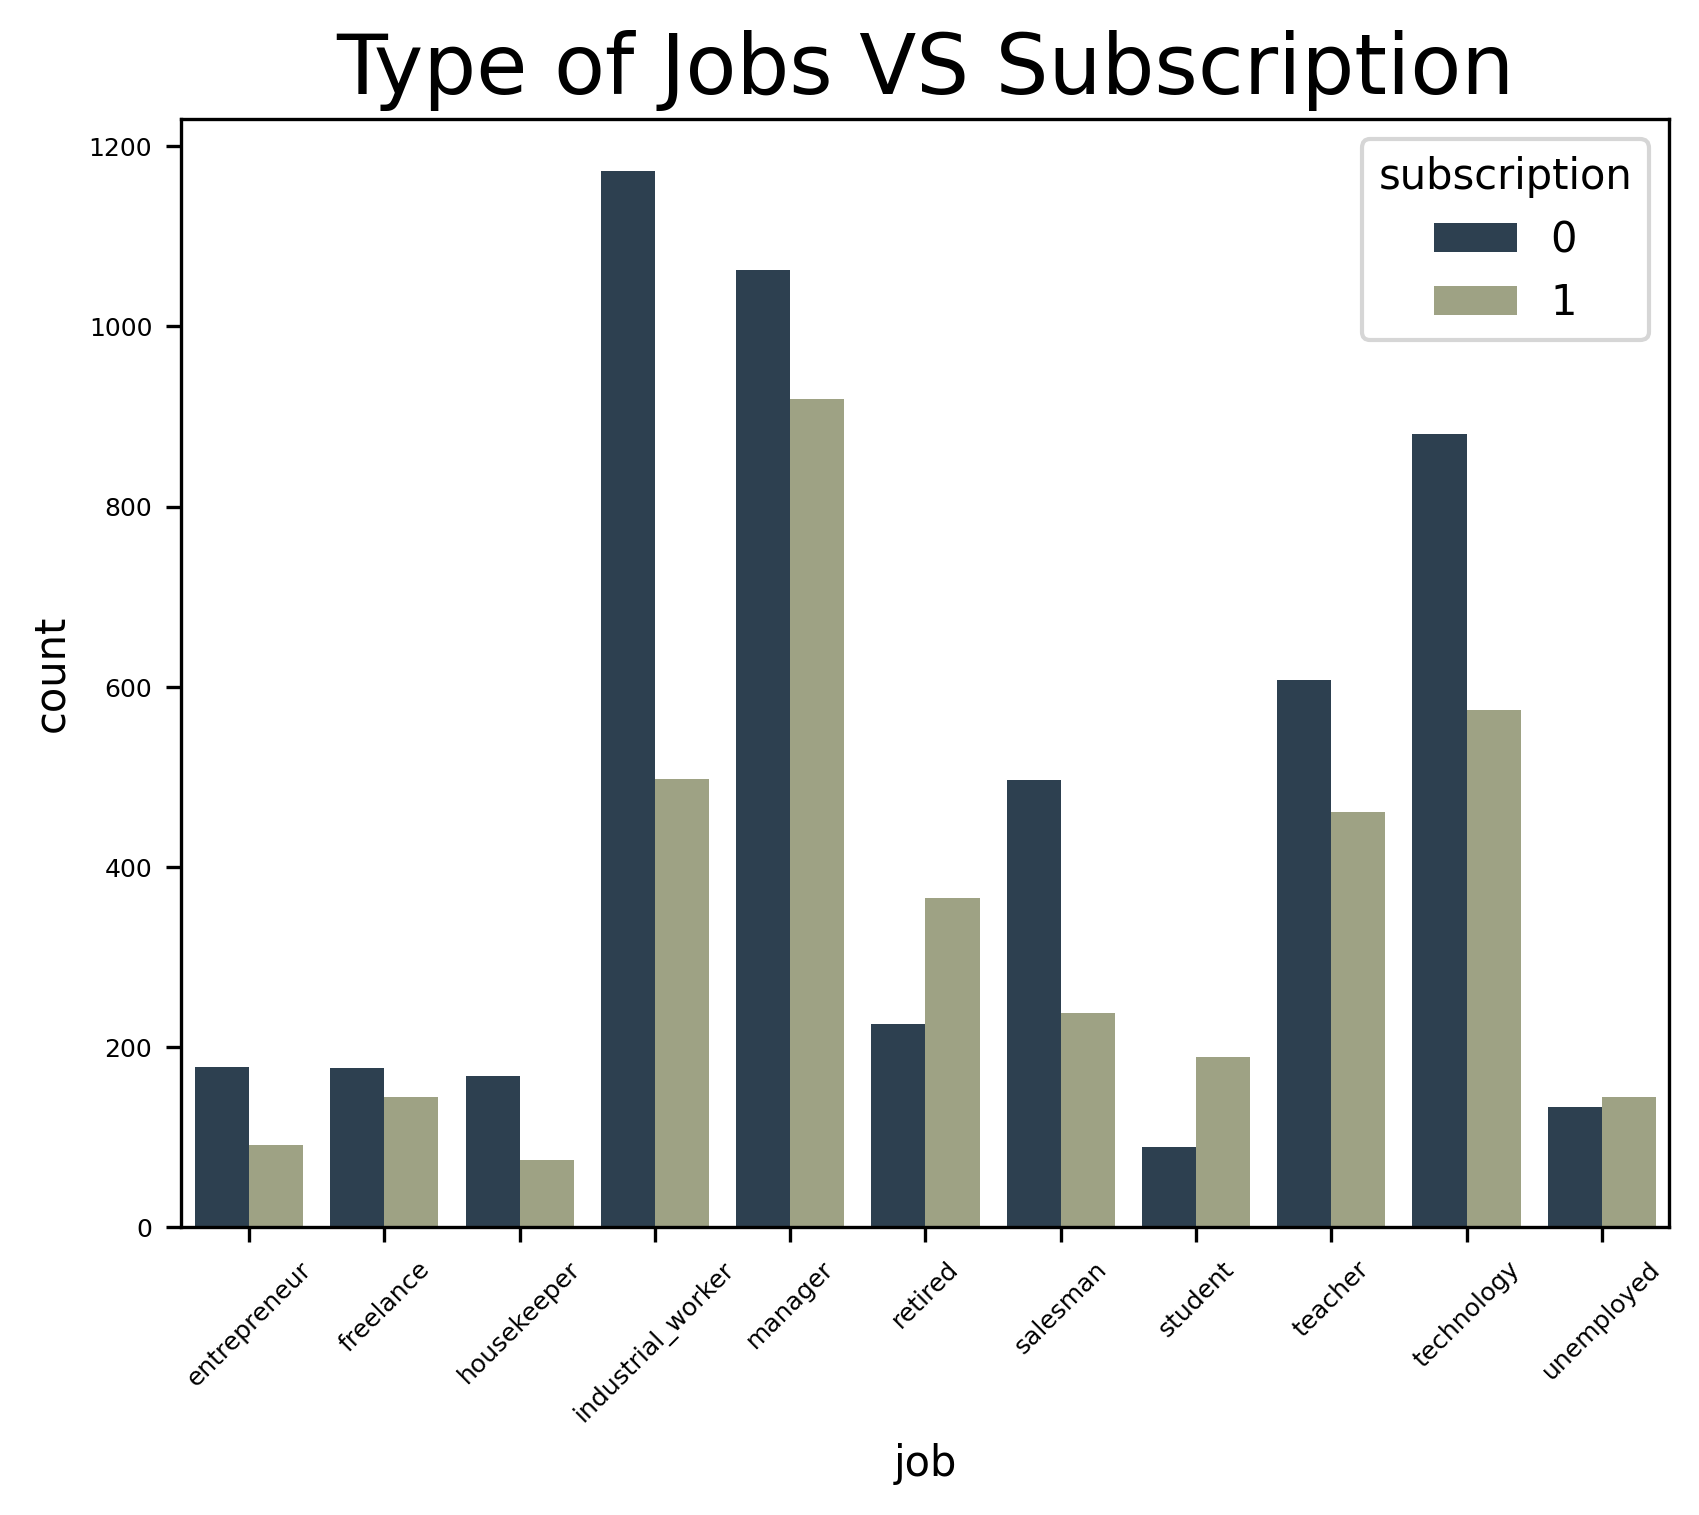

In [409]:

sns.countplot(x="job", hue="subscription", data=train, palette=colors_subscription)

plt.xticks(rotation=45)
plt.title("Type of Jobs VS Subscription", fontsize=18)

plt.xticks(fontsize=6)
plt.yticks(fontsize=6)

(array([   0.,  500., 1000., 1500., 2000., 2500., 3000., 3500.]), [Text(0, 0.0, '0'), Text(0, 500.0, '500'), Text(0, 1000.0, '1000'), Text(0, 1500.0, '1500'), Text(0, 2000.0, '2000'), Text(0, 2500.0, '2500'), Text(0, 3000.0, '3000'), Text(0, 3500.0, '3500')])

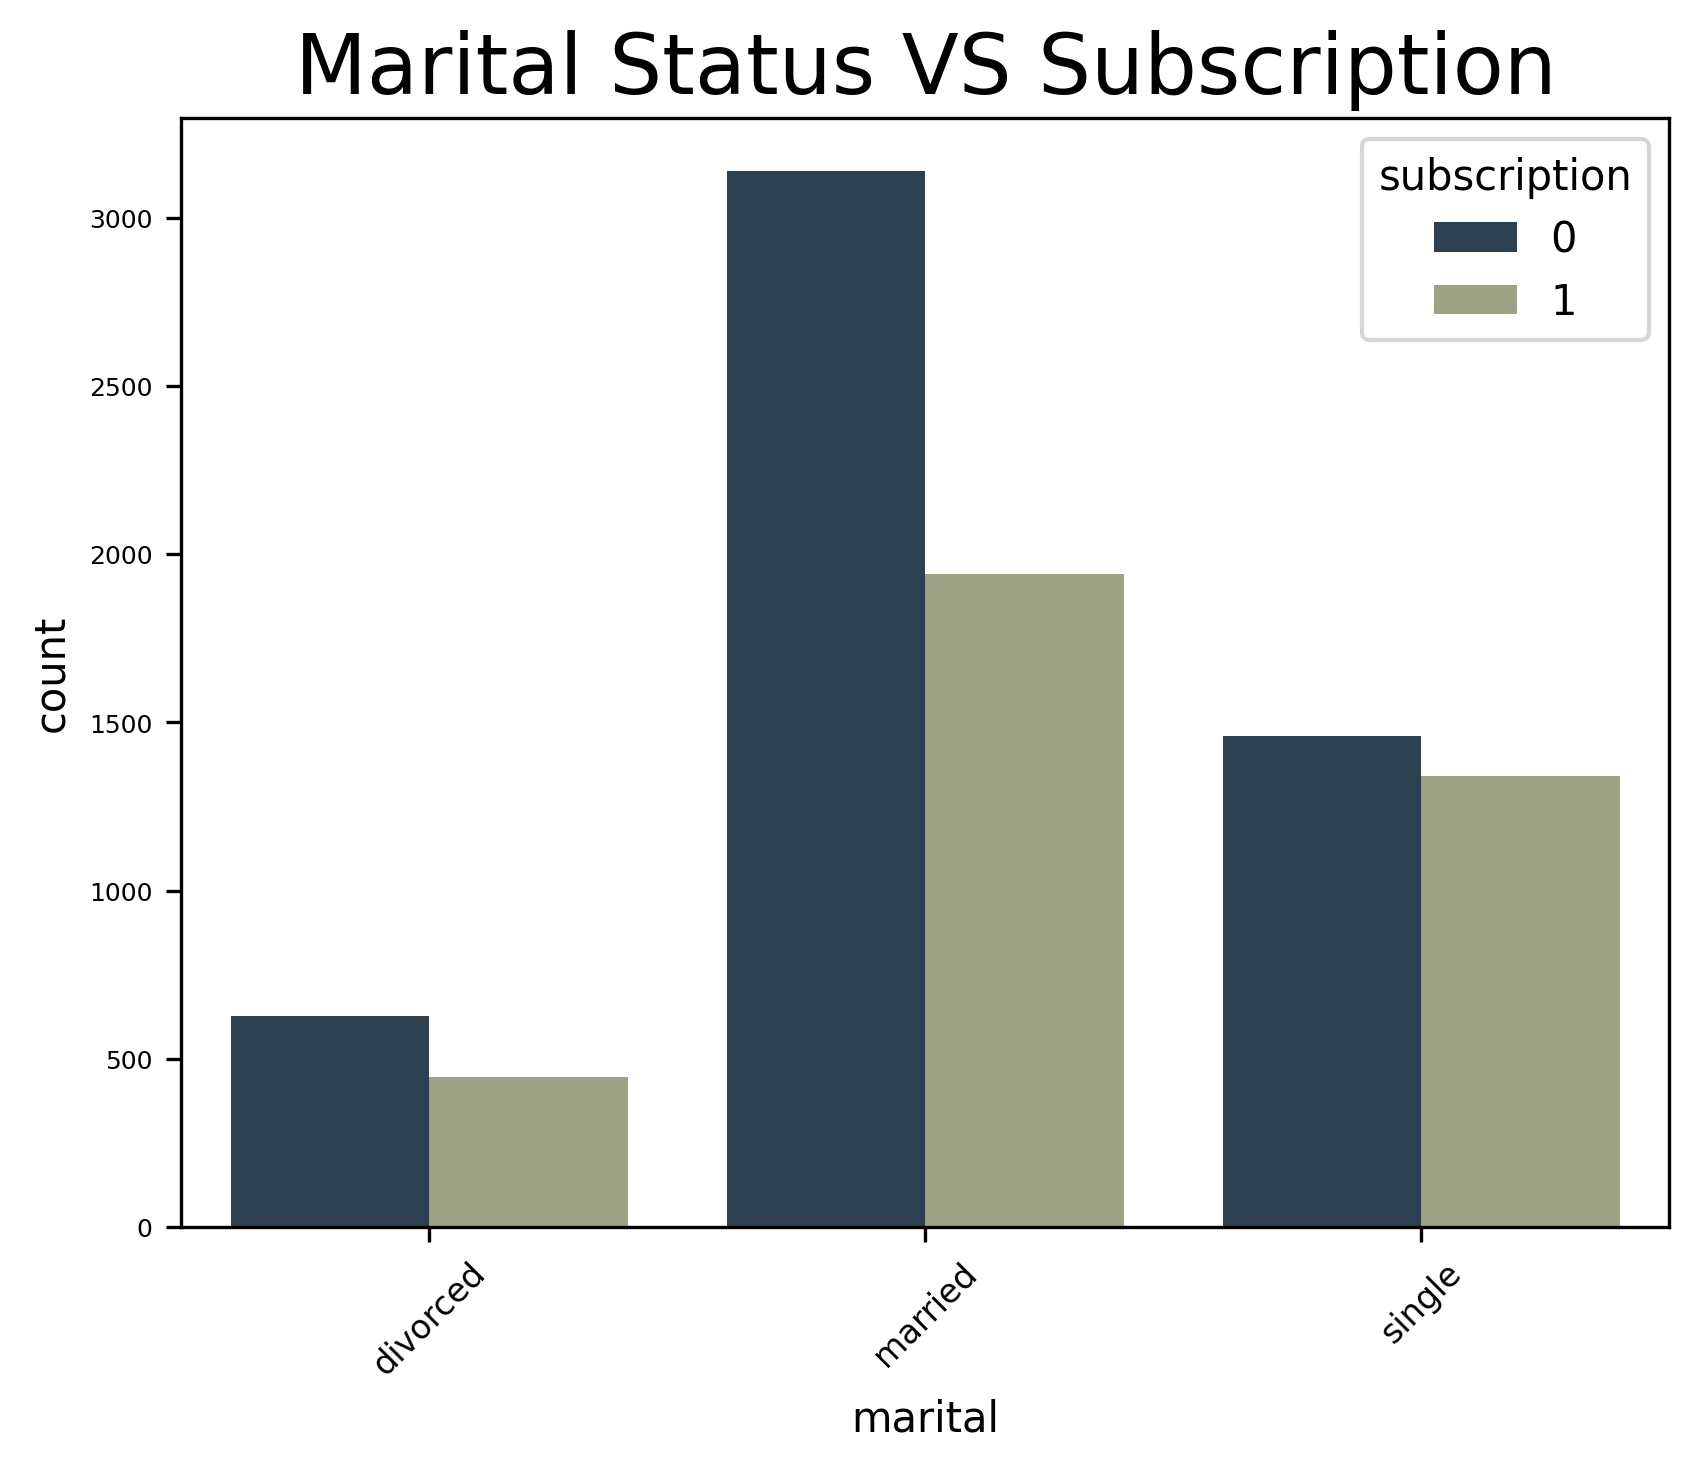

In [410]:

sns.countplot(x="marital", hue="subscription", data=train, palette=colors_subscription)

plt.xticks(rotation=45)
plt.title("Marital Status VS Subscription", fontsize=18)

plt.xticks(fontsize=8)
plt.yticks(fontsize=6)

(array([   0.,  500., 1000., 1500., 2000., 2500., 3000.]), [Text(0, 0.0, '0'), Text(0, 500.0, '500'), Text(0, 1000.0, '1000'), Text(0, 1500.0, '1500'), Text(0, 2000.0, '2000'), Text(0, 2500.0, '2500'), Text(0, 3000.0, '3000')])

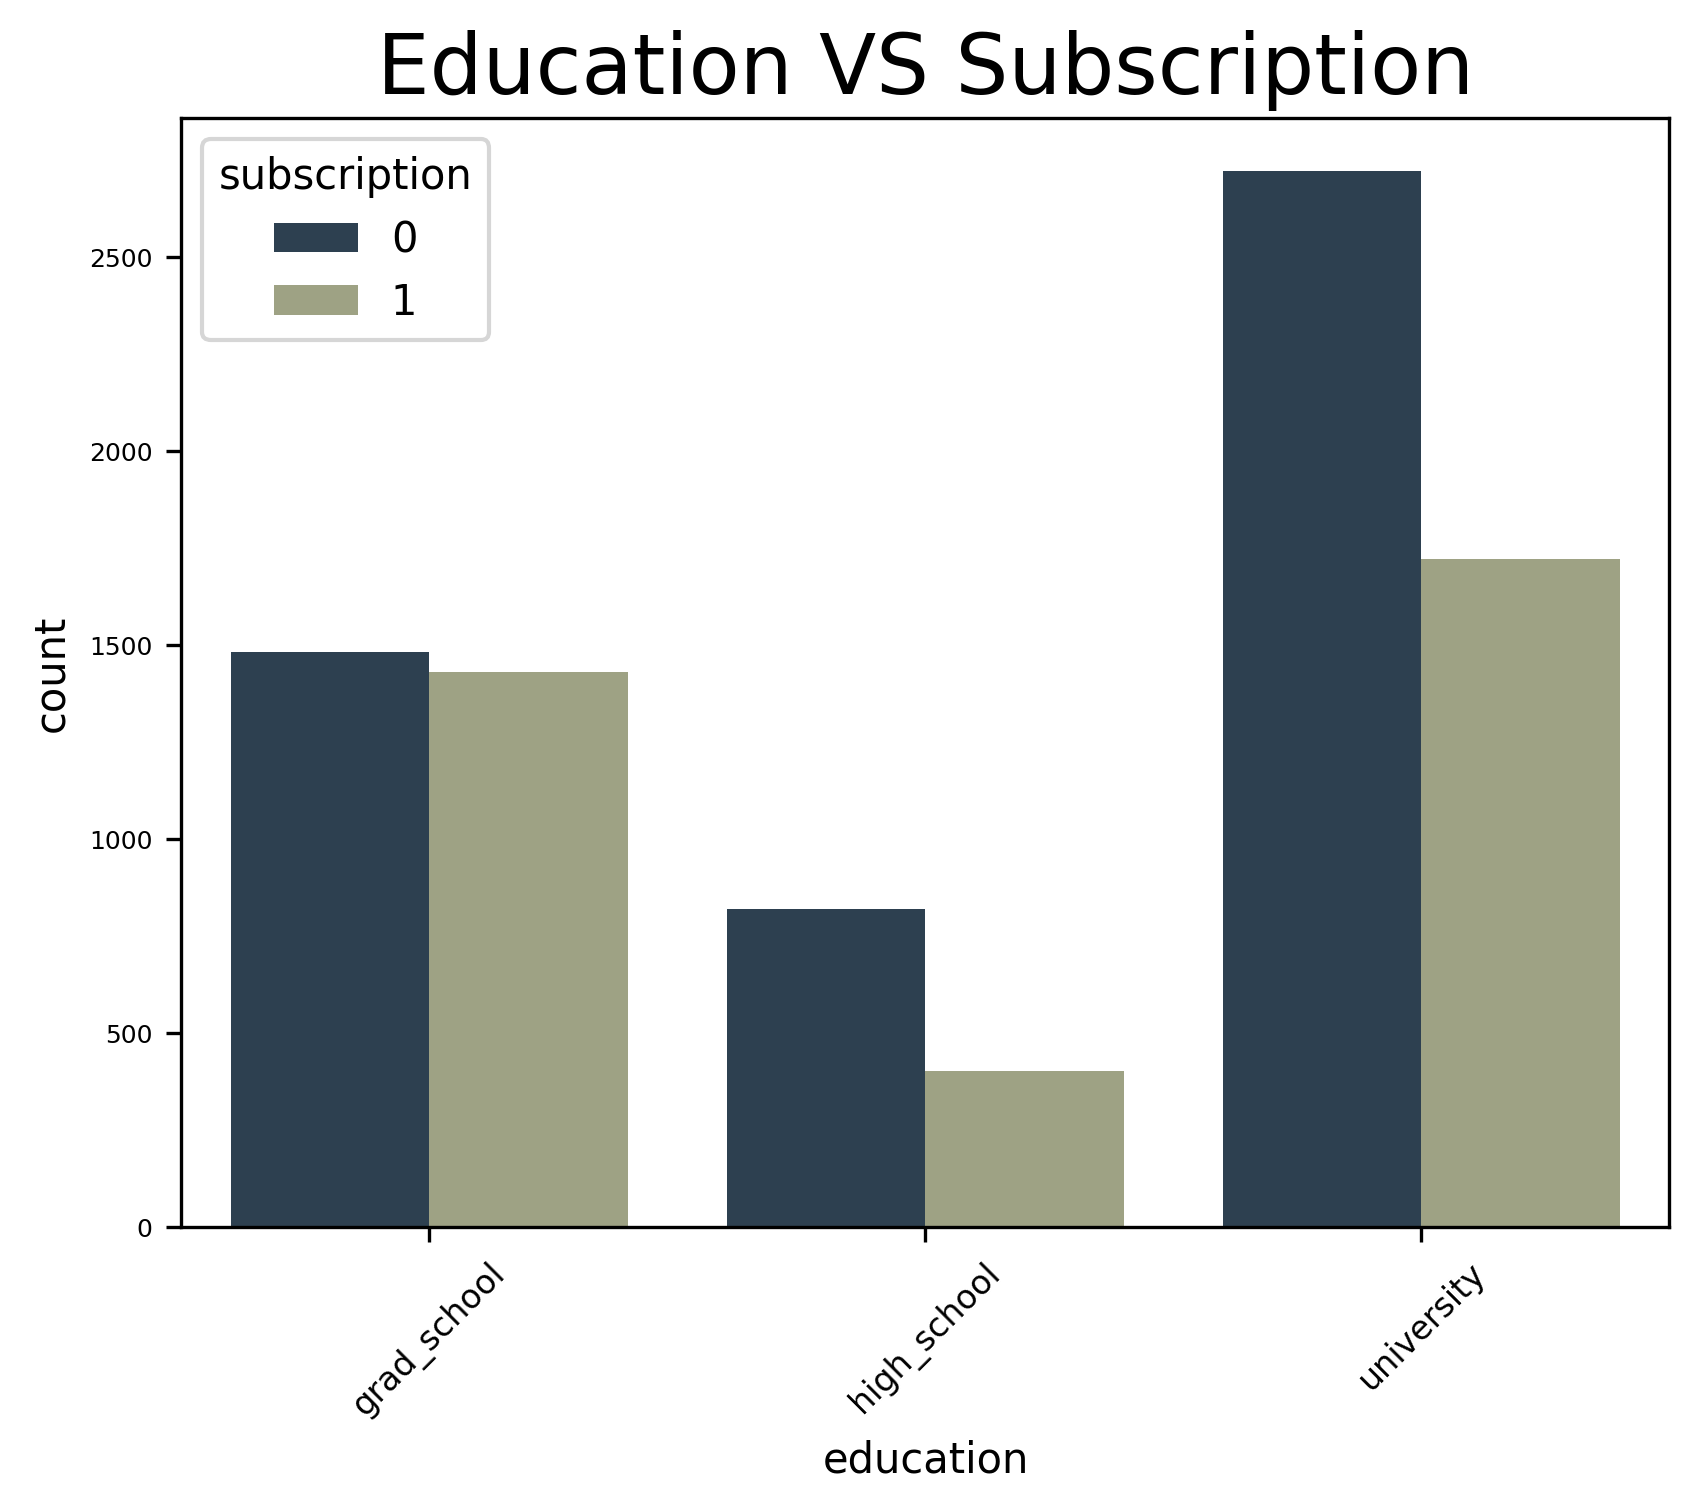

In [411]:

sns.countplot(x="education", hue="subscription", data=train, palette=colors_subscription)

plt.xticks(rotation=45)
plt.title("Education VS Subscription", fontsize=18)

plt.xticks(fontsize=8)
plt.yticks(fontsize=6)

(array([  0.,  50., 100., 150., 200., 250., 300., 350., 400.]), [Text(0, 0.0, '0'), Text(0, 50.0, '50'), Text(0, 100.0, '100'), Text(0, 150.0, '150'), Text(0, 200.0, '200'), Text(0, 250.0, '250'), Text(0, 300.0, '300'), Text(0, 350.0, '350'), Text(0, 400.0, '400')])

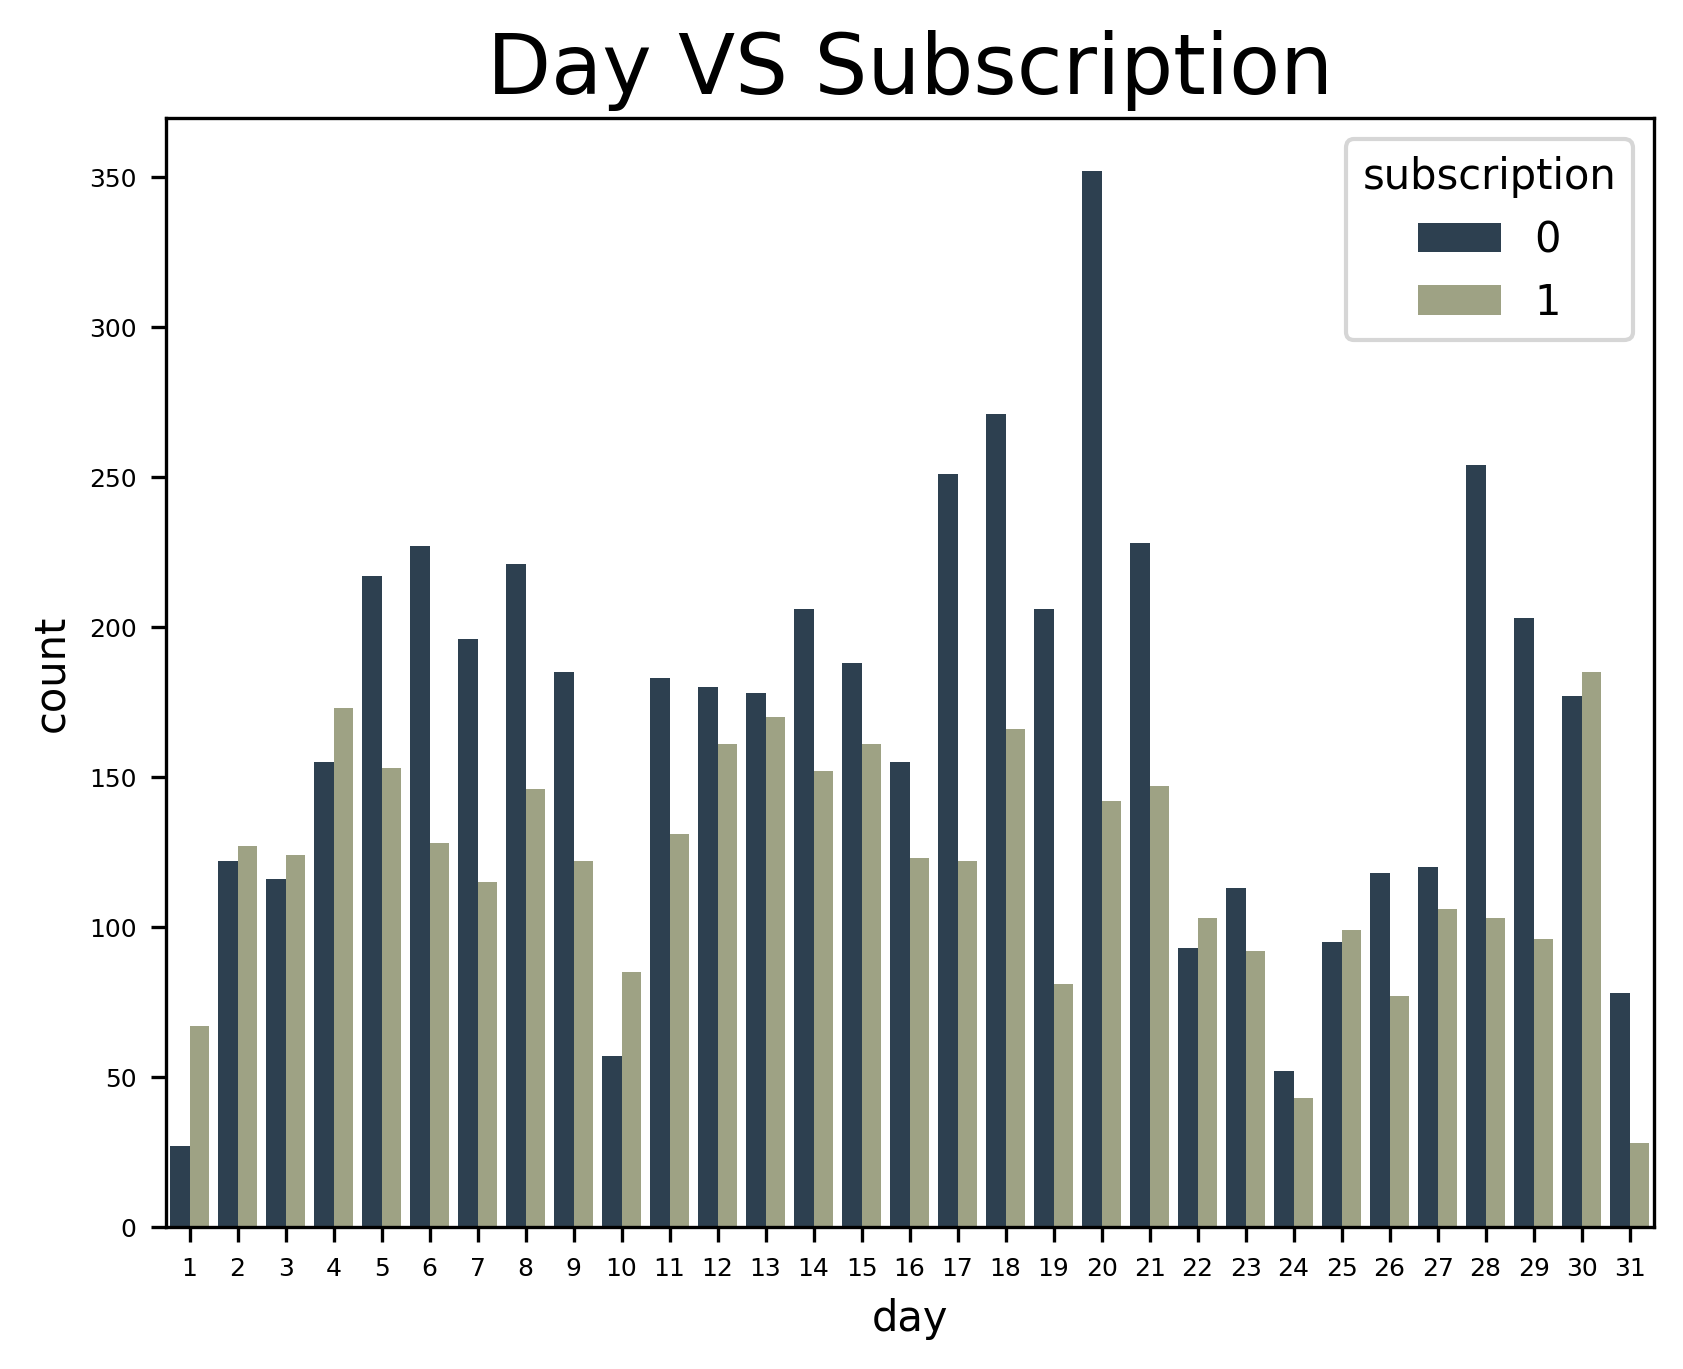

In [412]:

sns.countplot(x="day", hue="subscription", data=train, palette=colors_subscription)

plt.title("Day VS Subscription", fontsize=18)

plt.xticks(fontsize=6)
plt.yticks(fontsize=6)

(array([   0.,  250.,  500.,  750., 1000., 1250., 1500., 1750., 2000.]), [Text(0, 0.0, '0'), Text(0, 250.0, '250'), Text(0, 500.0, '500'), Text(0, 750.0, '750'), Text(0, 1000.0, '1000'), Text(0, 1250.0, '1250'), Text(0, 1500.0, '1500'), Text(0, 1750.0, '1750'), Text(0, 2000.0, '2000')])

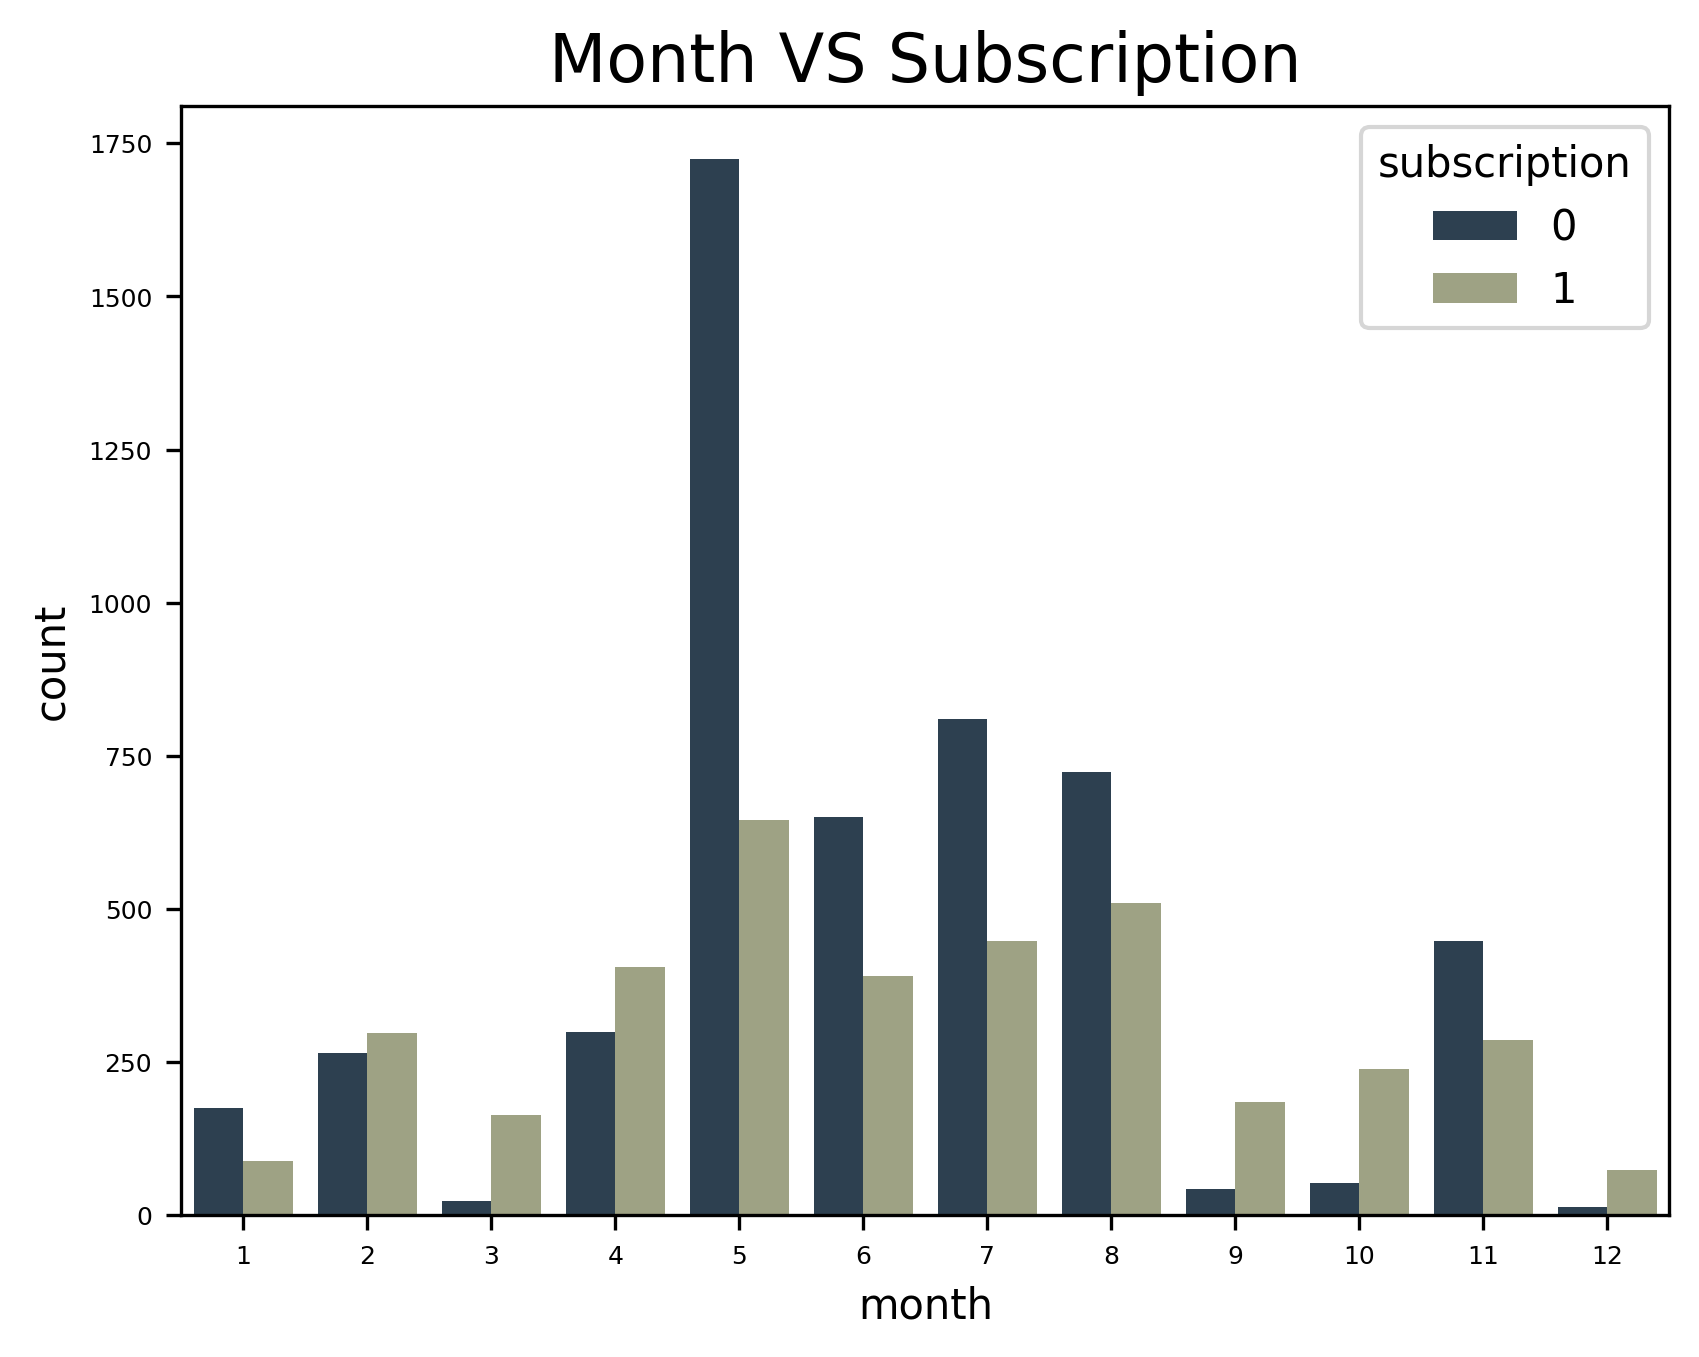

In [422]:

sns.countplot(x="month", hue="subscription", data=train, palette=colors_subscription)

plt.title("Month VS Subscription", fontsize=16)

plt.xticks(fontsize=6)
plt.yticks(fontsize=6)

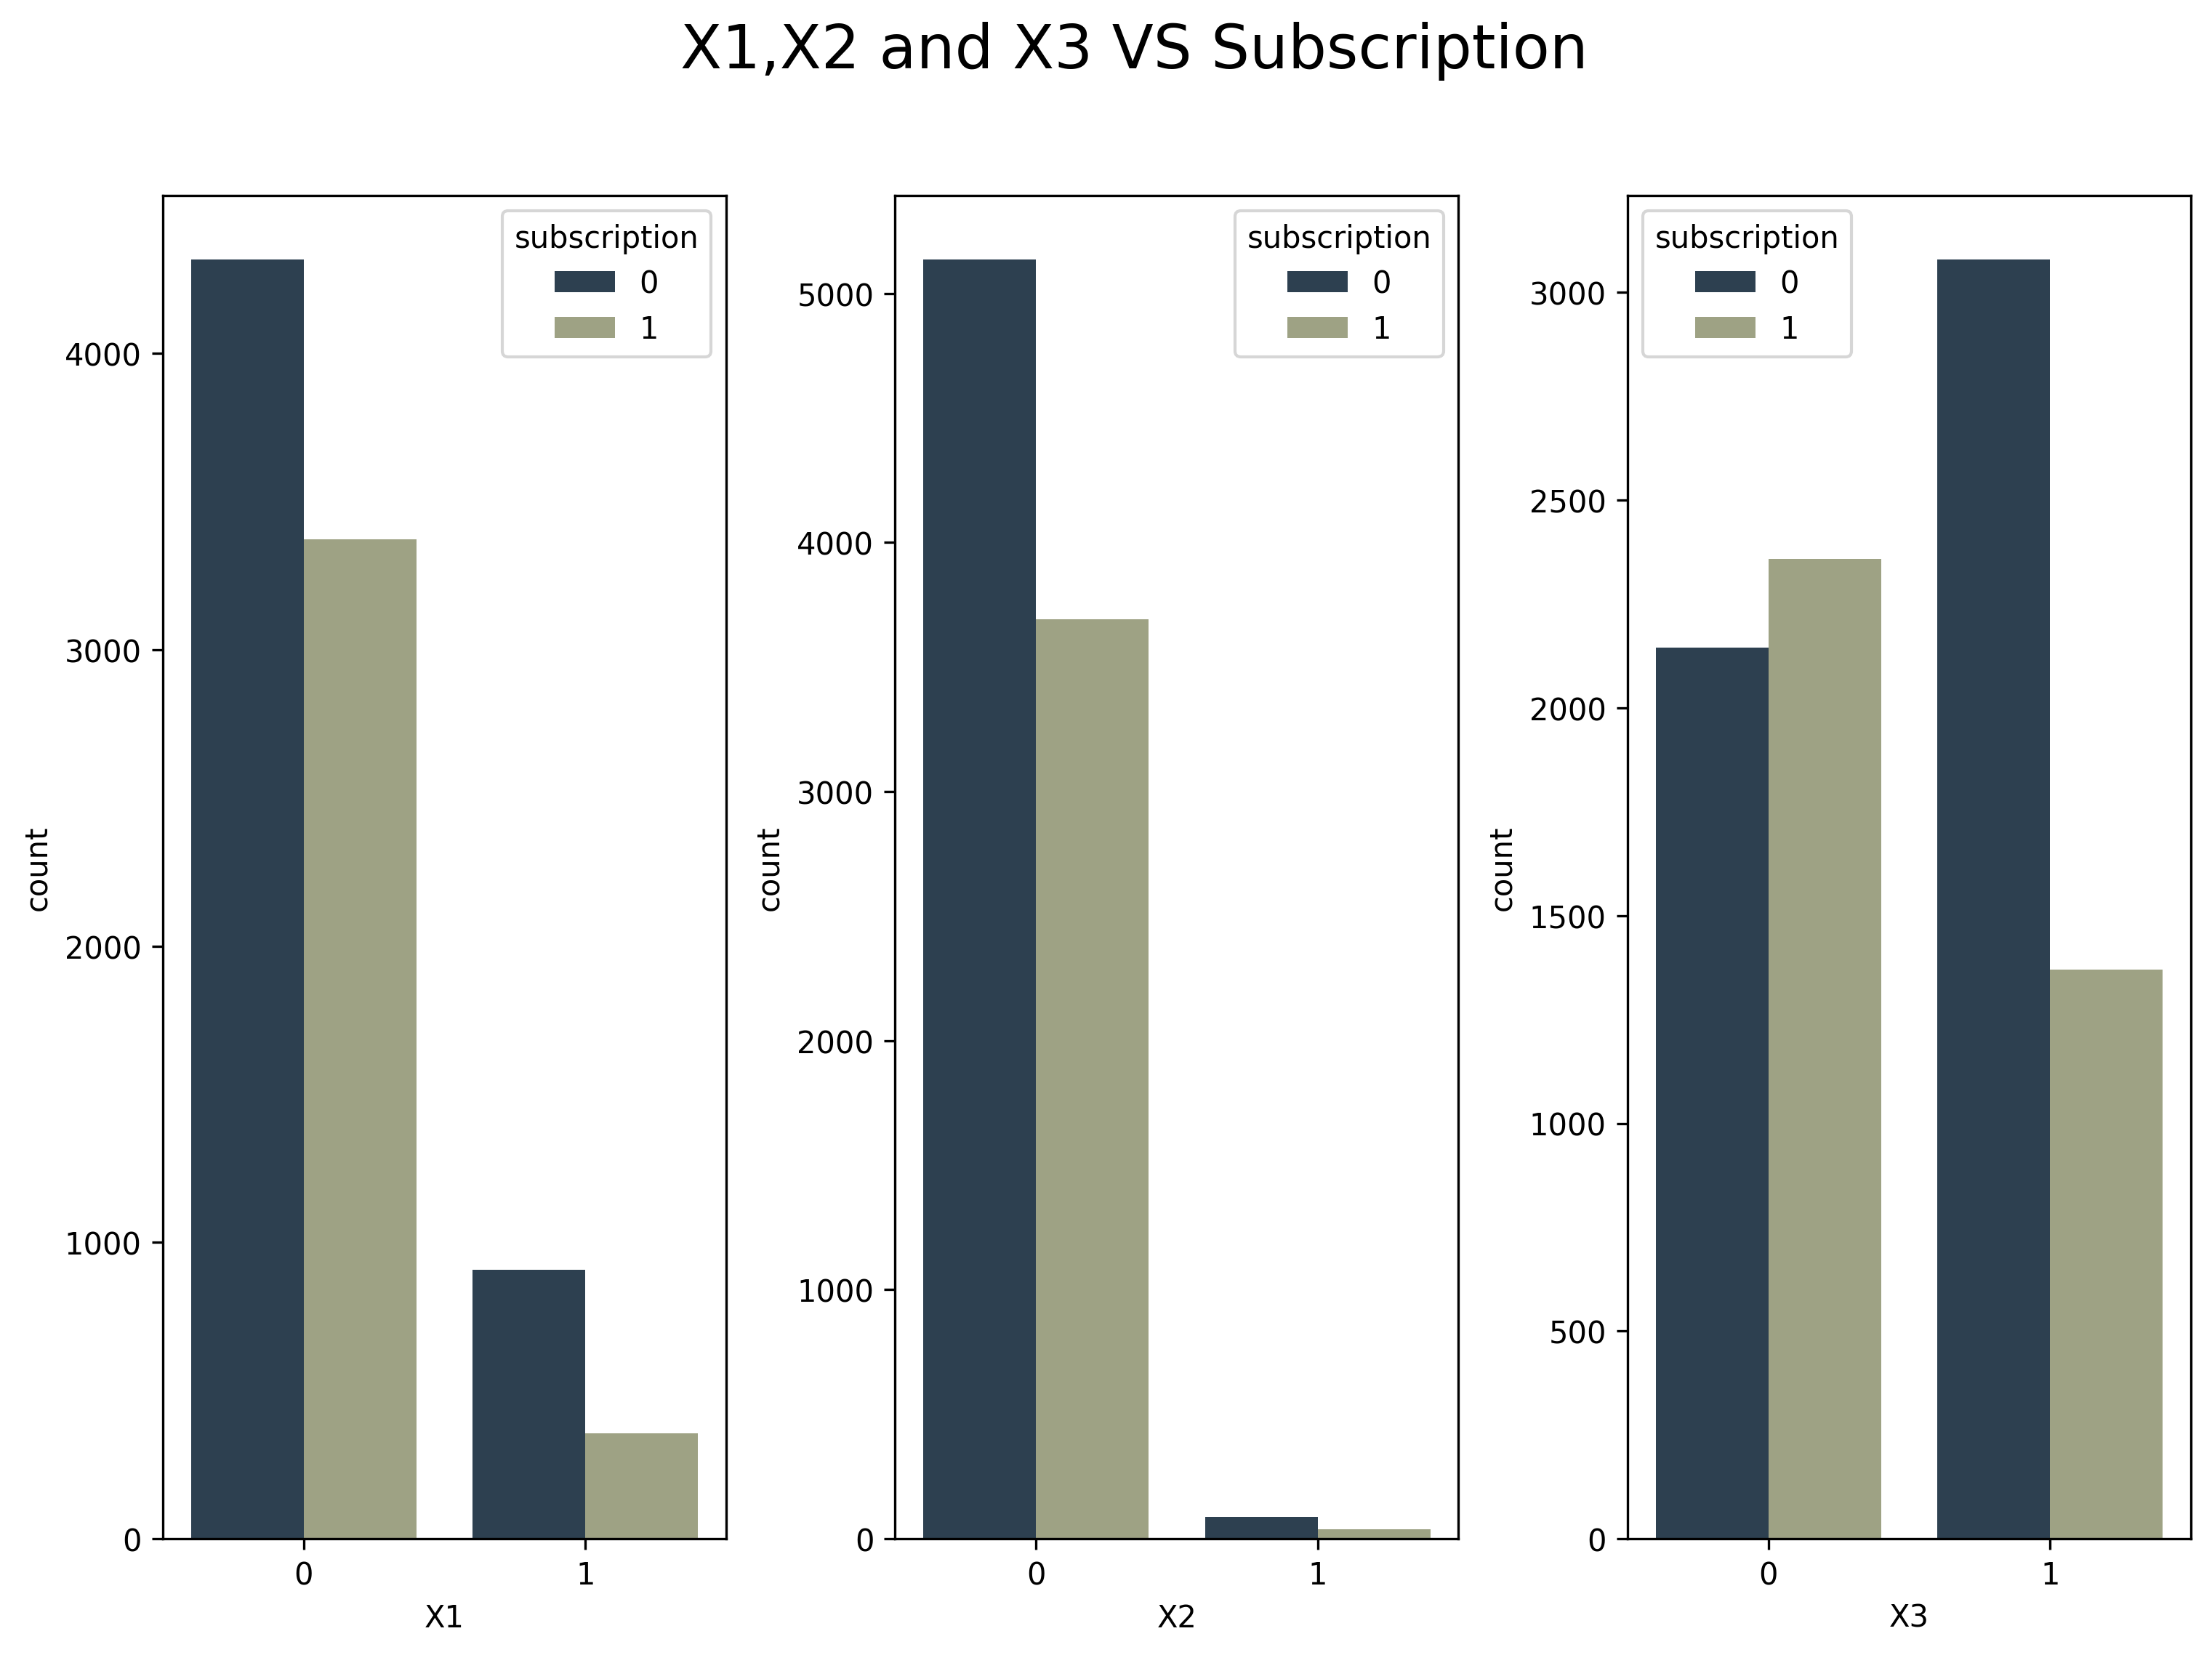

In [414]:
f, axes = plt.subplots(1, 3)

sns.countplot(x="X1", hue="subscription", data=train, palette=colors_subscription, ax=axes[0])
sns.countplot(x="X2", hue="subscription", data=train, palette=colors_subscription, ax=axes[1])
sns.countplot(x="X3", hue="subscription", data=train, palette=colors_subscription, ax=axes[2])

# Set the title for the figure
plt.suptitle("X1,X2 and X3 VS Subscription ", fontsize=20)

# Set the figure size
fig = plt.gcf()
fig.set_size_inches(12, 8)

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.3)

# Show the combined bar plots
plt.show()

## __Correlation Map__

/var/folders/j0/m71dtf9j0rvddgqlps9swgxc0000gn/T/ipykernel_41286/1257374829.py:6: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = train.corr()


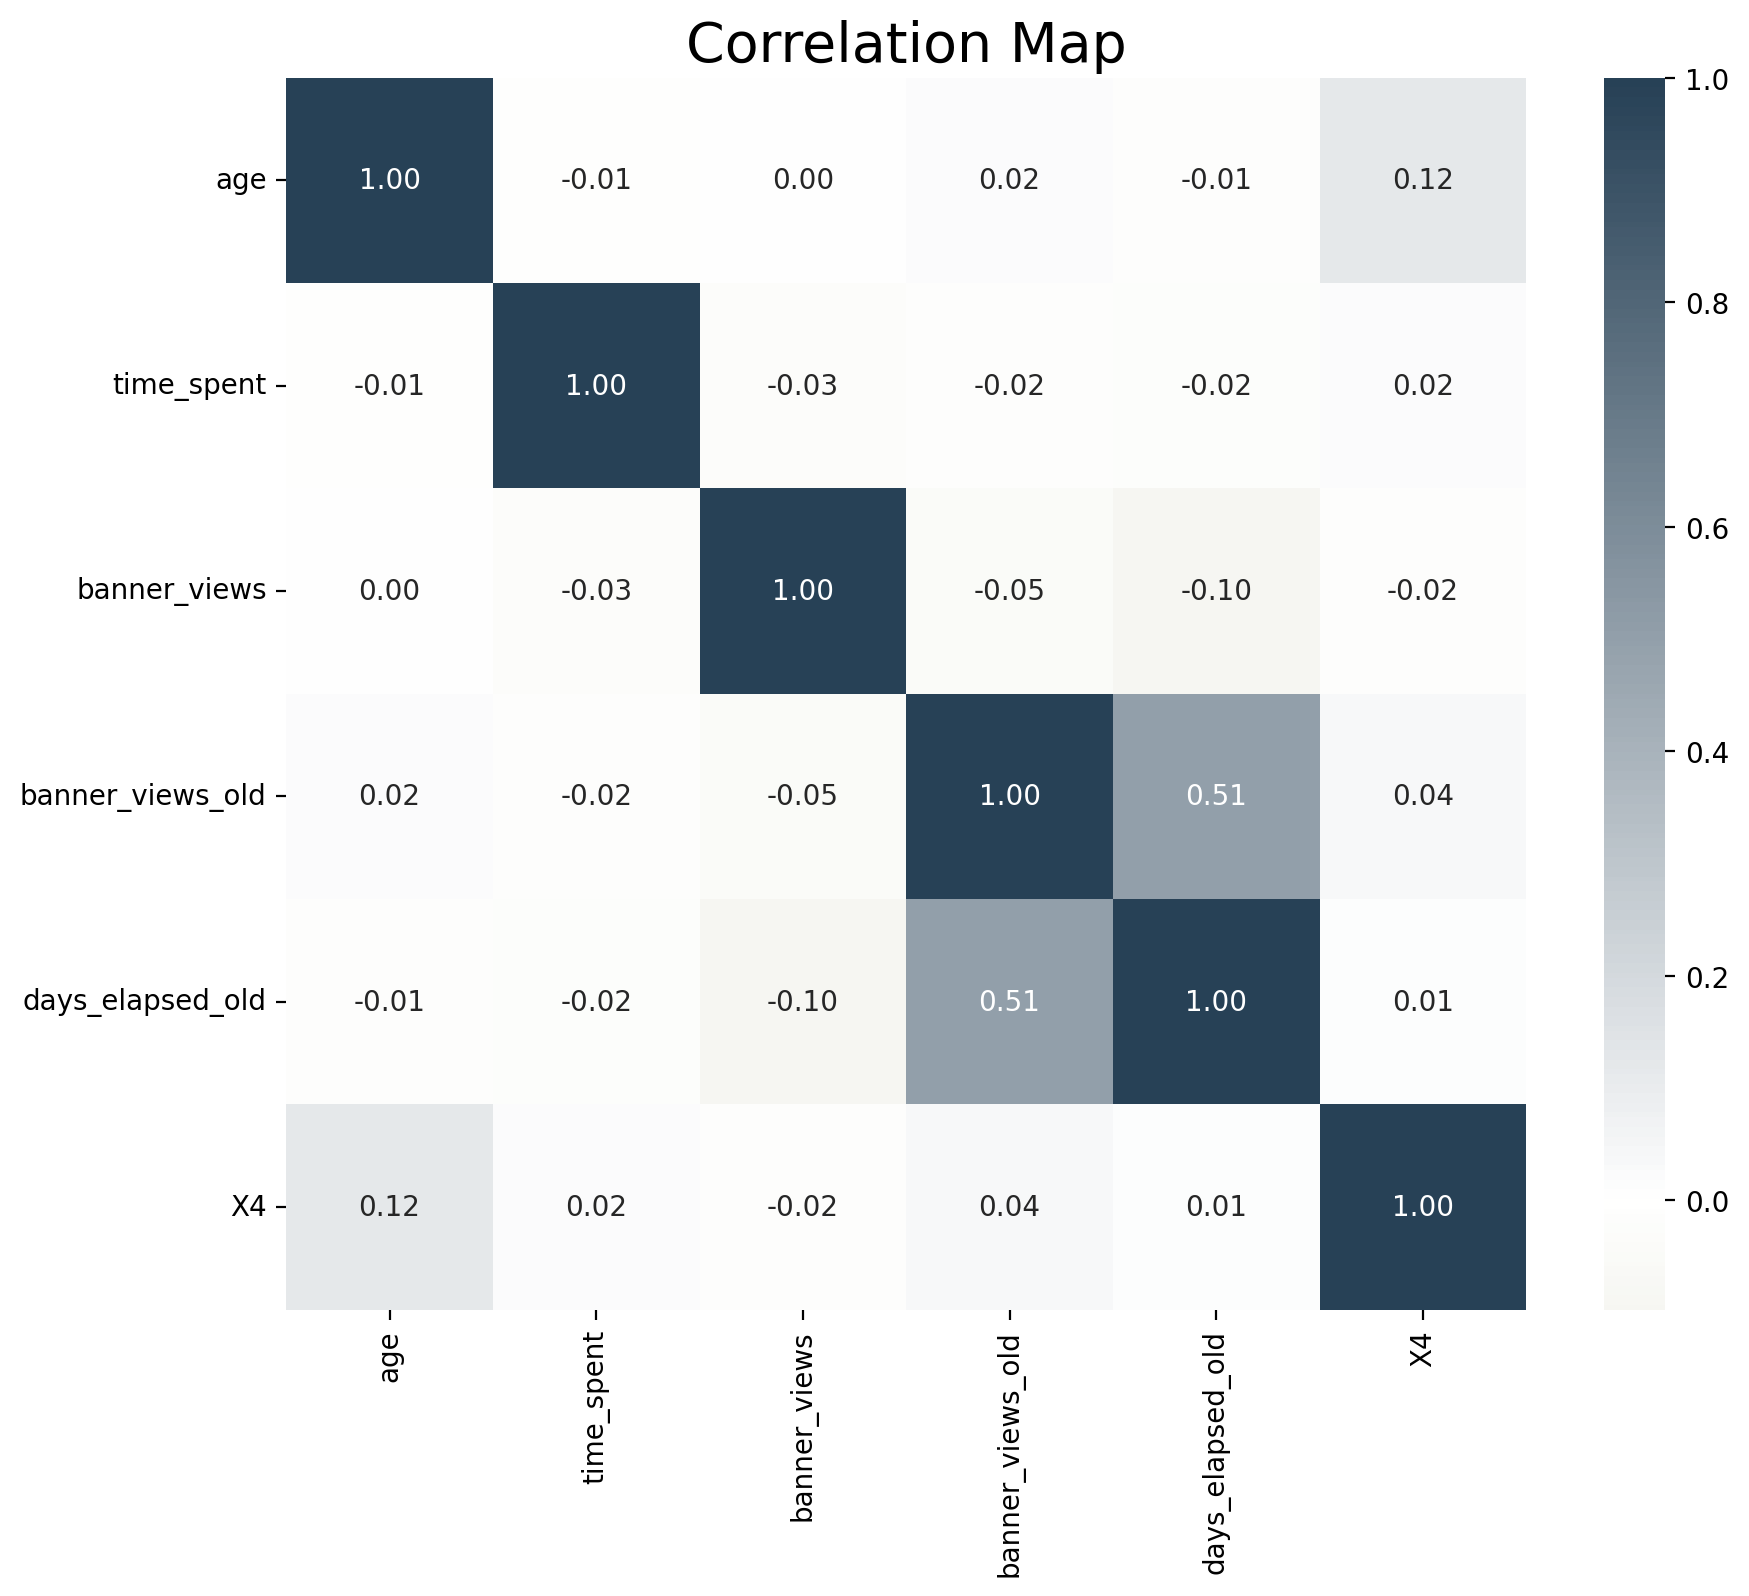

In [443]:
mpl.rcParams['figure.dpi']= 200

custom_cmap = mcolors.LinearSegmentedColormap.from_list("", [second_col, "white", main_col])

# Calculate the correlation matrix using pandas
corr_matrix = train.corr()

# Create a figure with a specific size using plt.subplots()
fig, ax = plt.subplots(figsize=(10, 8))

# Create a heatmap of the correlation matrix using sns.heatmap()
sns.heatmap(corr_matrix, annot=True, cmap=custom_cmap, fmt='.2f', center=0)

# Add a title to the plot
ax.set_title("Correlation Map", fontsize=20)

# Show the plot
plt.show()

We don't have strong __correlations__ among our set of numeric variables, mostly under 0.7 or above -0.7. Therefore there is no risk of __multicolinearity__.

# __Data Featuring and Engineering__

## __Scaling__

In [425]:
train_num = train[train_numeric]
train_cat = train[train_categorical]

test_num = test[test_numeric]
test_cat = test[test_categorical]

# create a StandardScaler object
scaler = StandardScaler()

# fit and transform the scaler on the numerical variables
scaler.fit(train_num)
train_num = pd.DataFrame(scaler.transform(train_num), columns=train_num.columns, index=train_num.index)
test_num = pd.DataFrame(scaler.transform(test_num),columns=test_num.columns, index=test_num.index)

# merge again 
train_scale = pd.merge(train_num, train_cat, how="left", on=["Id"])
test_scale = pd.merge(test_num, test_cat, how="left", on=["Id"])

### Train

In [426]:
train_scale.head()

age  time_spent  banner_views  banner_views_old  days_elapsed_old  \
Id                                                                           
0  -1.134397    0.572110      0.162700          1.543875          1.365471   
1   0.584160   -0.241413     -0.545538          0.114732          0.275678   
2  -1.220325   -0.534281      0.162700         -0.361649         -0.469480   
3   0.240448   -0.593446     -0.191419          0.114732          2.976874   
4  -1.048469   -0.072791     -0.191419          0.591113          0.871804   

          X4                job   marital    education      device day month  \
Id                                                                             
0  -0.456189          freelance   married  grad_school  smartphone   4     2   
1  -0.368554  industrial_worker   married   university  smartphone  30     4   
2  -0.611350            teacher   married   university  smartphone  14     7   
3   0.176463         unemployed  divorced   university  smartphone  13     5   
4  -0.022516            manager    single  grad_school  smartphone  26     4   

   outcome_old X1 X2 X3 subscription  
Id                                    
0      failure  0  0  1            1  
1      success  0  0  0            1  
2          NaN  0  1  1            0  
3        other  0  0  1            0  
4      success  0  0  0            1

### Test

In [427]:
test_scale.head()

age  time_spent  banner_views  banner_views_old  days_elapsed_old  \
Id                                                                           
0   1.013799   -0.702902     -0.545538         -0.361649          -0.46948   
1   1.701222   -0.481032     -0.545538         -0.361649          -0.46948   
2   0.841943   -0.442575     -0.545538         -0.361649          -0.46948   
3  -0.618830   -0.217746     -0.191419         -0.361649          -0.46948   
4  -0.962542   -0.058000     -0.191419         -0.361649          -0.46948   

          X4                job  marital    education      device day month  \
Id                                                                            
0  -0.067234            retired  married   university         NaN  17     6   
1  -0.376057            manager  married  grad_school  smartphone  20     4   
2  -0.357749  industrial_worker  married   university         NaN   4     7   
3  -0.547425            manager  married  grad_school         NaN  28     5   
4   2.810310            manager  married  grad_school  smartphone   4     5   

   outcome_old X1 X2 X3  
Id                       
0          NaN  0  0  1  
1          NaN  0  0  0  
2          NaN  0  0  0  
3          NaN  0  0  1  
4          NaN  0  0  0

## __Hot-Encoding__

In [429]:
train_hot = pd.get_dummies(train_scale, columns=['job','marital','education','device','day','month','outcome_old'])
test_hot = pd.get_dummies(test_scale, columns=['job','marital','education','device','day','month','outcome_old'])

### Train

In [494]:
train_hot = train_hot.astype({'X1':'uint8', 'X2':'uint8', 'X3':'uint8'})
train_hot.head()

age  time_spent  banner_views  banner_views_old  days_elapsed_old  \
Id                                                                           
0  -1.134397    0.572110      0.162700          1.543875          1.365471   
1   0.584160   -0.241413     -0.545538          0.114732          0.275678   
2  -1.220325   -0.534281      0.162700         -0.361649         -0.469480   
3   0.240448   -0.593446     -0.191419          0.114732          2.976874   
4  -1.048469   -0.072791     -0.191419          0.591113          0.871804   

          X4  X1  X2  X3 subscription  ...  month_6  month_7  month_8  \
Id                                     ...                              
0  -0.456189   0   0   1            1  ...        0        0        0   
1  -0.368554   0   0   0            1  ...        0        0        0   
2  -0.611350   0   1   1            0  ...        0        1        0   
3   0.176463   0   0   1            0  ...        0        0        0   
4  -0.022516   0   0   0            1  ...        0        0        0   

    month_9  month_10  month_11  month_12  outcome_old_failure  \
Id                                                               
0         0         0         0         0                    1   
1         0         0         0         0                    0   
2         0         0         0         0                    0   
3         0         0         0         0                    0   
4         0         0         0         0                    0   

    outcome_old_other  outcome_old_success  
Id                                          
0                   0                    0  
1                   0                    1  
2                   0                    0  
3                   1                    0  
4                   0                    1  

[5 rows x 75 columns]

### Test

In [495]:
test_hot = test_hot.astype({'X1':'uint8', 'X2':'uint8', 'X3':'uint8'})
test_hot.head()

age  time_spent  banner_views  banner_views_old  days_elapsed_old  \
Id                                                                           
0   1.013799   -0.702902     -0.545538         -0.361649          -0.46948   
1   1.701222   -0.481032     -0.545538         -0.361649          -0.46948   
2   0.841943   -0.442575     -0.545538         -0.361649          -0.46948   
3  -0.618830   -0.217746     -0.191419         -0.361649          -0.46948   
4  -0.962542   -0.058000     -0.191419         -0.361649          -0.46948   

          X4  X1  X2  X3  job_entrepreneur  ...  month_6  month_7  month_8  \
Id                                          ...                              
0  -0.067234   0   0   1                 0  ...        1        0        0   
1  -0.376057   0   0   0                 0  ...        0        0        0   
2  -0.357749   0   0   0                 0  ...        0        1        0   
3  -0.547425   0   0   1                 0  ...        0        0        0   
4   2.810310   0   0   0                 0  ...        0        0        0   

    month_9  month_10  month_11  month_12  outcome_old_failure  \
Id                                                               
0         0         0         0         0                    0   
1         0         0         0         0                    0   
2         0         0         0         0                    0   
3         0         0         0         0                    0   
4         0         0         0         0                    0   

    outcome_old_other  outcome_old_success  
Id                                          
0                   0                    0  
1                   0                    0  
2                   0                    0  
3                   0                    0  
4                   0                    0  

[5 rows x 74 columns]

# __Train and Validation__

## Seperating Features and Target Variable

In [496]:
train_no_subscription = train_hot.drop('subscription', axis=1)
train_only_subscription = train_hot['subscription']

## Splitting Training and Validation

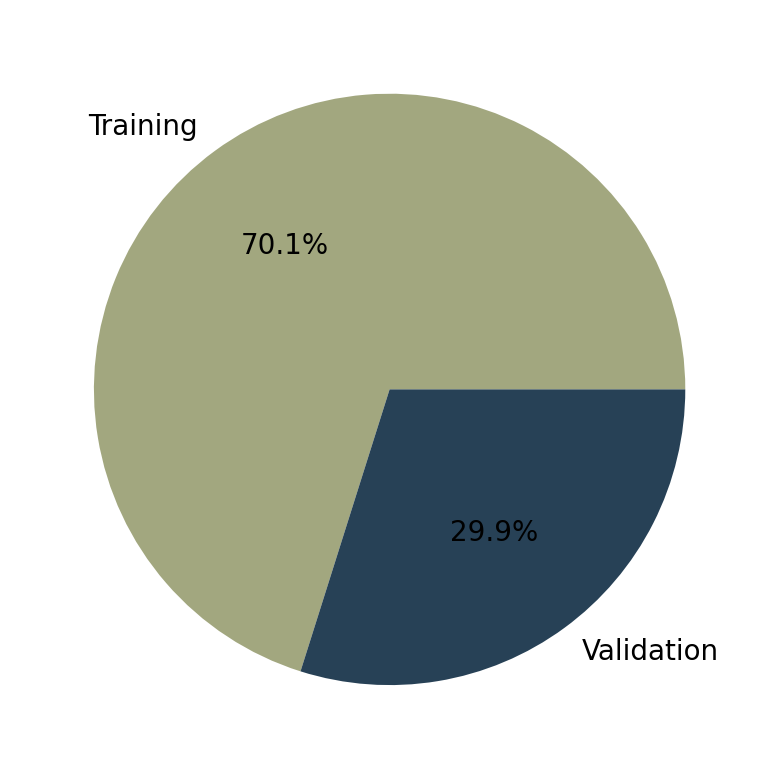

In [497]:
valid_size = 0.23

# Split the data into training and test sets
X_train, X_valid, Y_train, Y_valid = train_test_split(train_no_subscription, train_only_subscription, test_size=valid_size,  stratify=train_only_subscription)

# Checking Correct Split
Cond1 = X_train.shape[0] == Y_train.shape[0]
Cond2 = X_valid.shape[0] == Y_valid.shape[0]

#print("\nSame Size ?","\n\nFor Training:",Cond1,", For Validation:", Cond2)

PropTV = (X_valid.shape[0]/X_train.shape[0])*100
PropTR = (1-(X_valid.shape[0]/X_train.shape[0]))*100

#print("\nProportions between Training and Validation:","\n Training: ", round(PropTR,2),"%", "\n Validation: ",round(PropTV,2),"%")

mpl.rcParams['figure.dpi']= 200

mylabels = ["Training","Validation"]

y = np.array([PropTR,PropTV])

piecolors = [second_col,main_col]

plt.pie(y, labels = mylabels, colors = piecolors, autopct='%1.1f%%')
plt.show() 

# __Predictive Models__

In [499]:
mpl.rcParams['figure.dpi']= 150

custom_cmap2 = mcolors.LinearSegmentedColormap.from_list("", [main_col, "white", second_col])

In [500]:
def plot_ROC(true, predicted):
    RocCurveDisplay.from_predictions(
        true,
        predicted,
        color=second_col,
    )
    plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
    plt.axis("square")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.show()


def make_confusion_matrix(cf,
                          group_names= None,
                          categories= 'auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.

    Arguments
    ---------
    cf:            confusion matrix to be passed in

    group_names:   List of strings that represent the labels row by row to be shown in each square.

    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'

    count:         If True, show the raw number in the confusion matrix. Default is True.

    normalize:     If True, show the proportions for each category. Default is True.

    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.

    xyticks:       If True, show x and y ticks. Default is True.

    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.

    sum_stats:     If True, display summary statistics below the figure. Default is True.

    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.

    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.

    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            specificity = cf[0,0] / (cf[0,0] + cf[0,1])
            sensitivity = cf[1,1] / (cf[1,0] + cf[1,1])
            stats_text = "\n\nAccuracy={:0.3f}   Precision={:0.3f}   Recall={:0.3f}\n      F1 Score={:0.3f}   Sensitivity{:0.3f}   Specificity={:0.3f}".format(
                accuracy,precision,recall,f1_score, sensitivity,specificity)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)
    
    plt.show()


def plot_training(history_dict):
    acc = history_dict['accuracy']
    val_acc = history_dict['val_accuracy']
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']
    
    epochs = range(1, len(loss) + 1)
    
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, 'b--', label='Training')
    plt.plot(epochs, val_loss, 'r-', label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Cross-Entropy Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs, acc, 'b--', label='Training')
    plt.plot(epochs, val_acc, 'r-', label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    
    plt.show()

## Random Forests

In [476]:
from sklearn.ensemble import RandomForestClassifier

### No Tuning

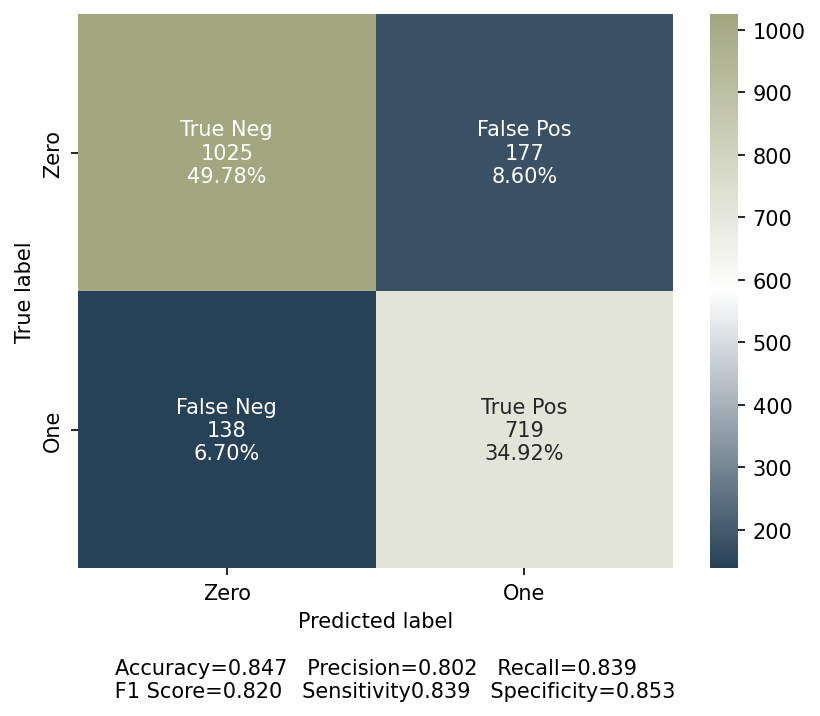

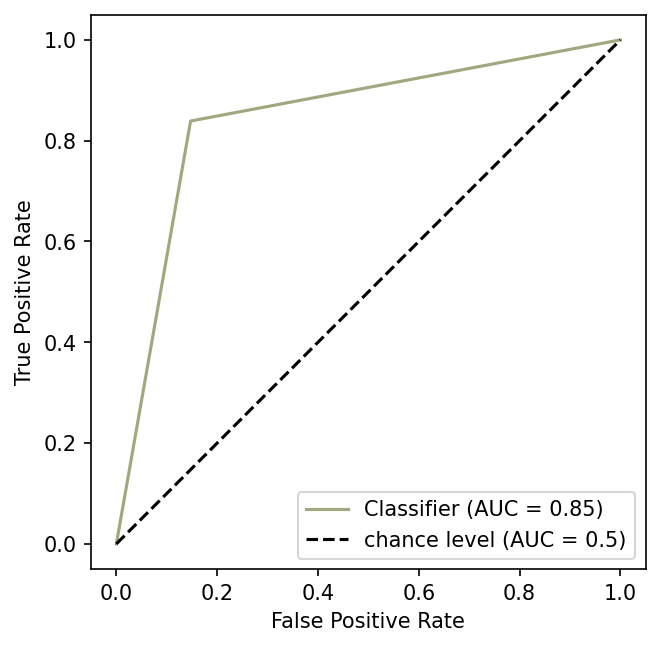

In [477]:
# create the Random Forest model
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# fit the model to the training data
rf.fit(X_train, Y_train)

# make predictions on the testing data
y_pred = rf.predict(X_valid)

make_confusion_matrix(confusion_matrix(Y_valid, y_pred), group_names=['True Neg','False Pos','False Neg','True Pos'],  categories=['Zero', 'One'], cmap=custom_cmap2)
plot_ROC(Y_valid, y_pred)


### Tuning

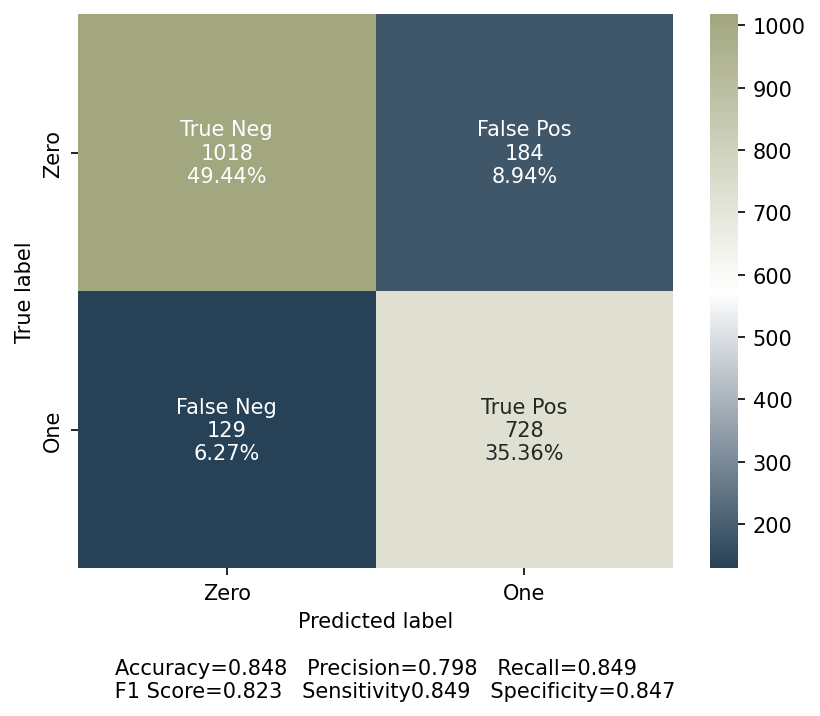

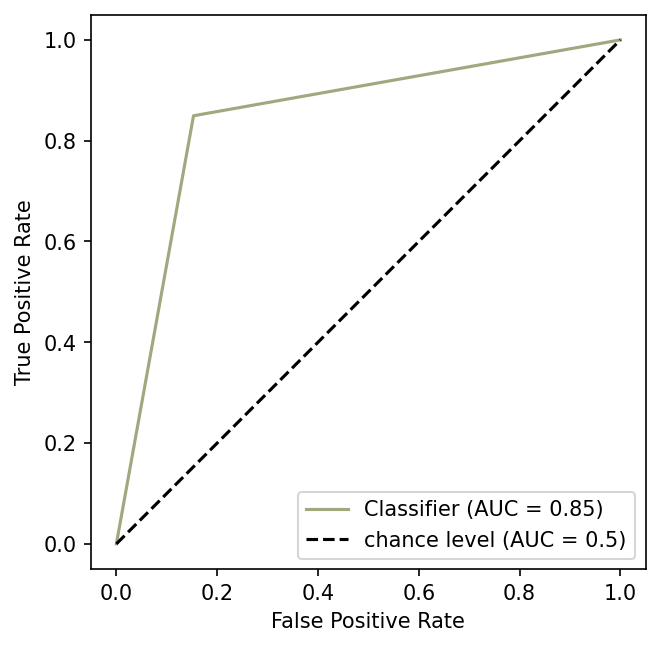

In [478]:
rf = RandomForestClassifier(random_state=42)

# set up the hyperparameter grid to search over
param_grid = {'n_estimators': [50, 100, 200],
              'max_depth': [None, 5, 10],
              'min_samples_split': [2, 5, 10],
              'min_samples_leaf': [1, 2, 4]}

# set up the GridSearchCV object
grid_search = GridSearchCV(rf, param_grid, cv=5)

# fit the GridSearchCV object to the training data
grid_search.fit(X_train, Y_train)


rf = RandomForestClassifier(n_estimators=grid_search.best_params_['n_estimators'],
                            max_depth=grid_search.best_params_['max_depth'],
                            min_samples_split=grid_search.best_params_['min_samples_split'],
                            min_samples_leaf=grid_search.best_params_['min_samples_leaf'],
                            random_state=42)

# fit the model to the entire training data
rf.fit(X_train, Y_train)

# make predictions on the testing data
y_pred = rf.predict(X_valid)

make_confusion_matrix(confusion_matrix(Y_valid, y_pred), group_names=['True Neg','False Pos','False Neg','True Pos'],  categories=['Zero', 'One'], cmap=custom_cmap2)
plot_ROC(Y_valid, y_pred)

## Bagging Trees

In [480]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

### No Tuning

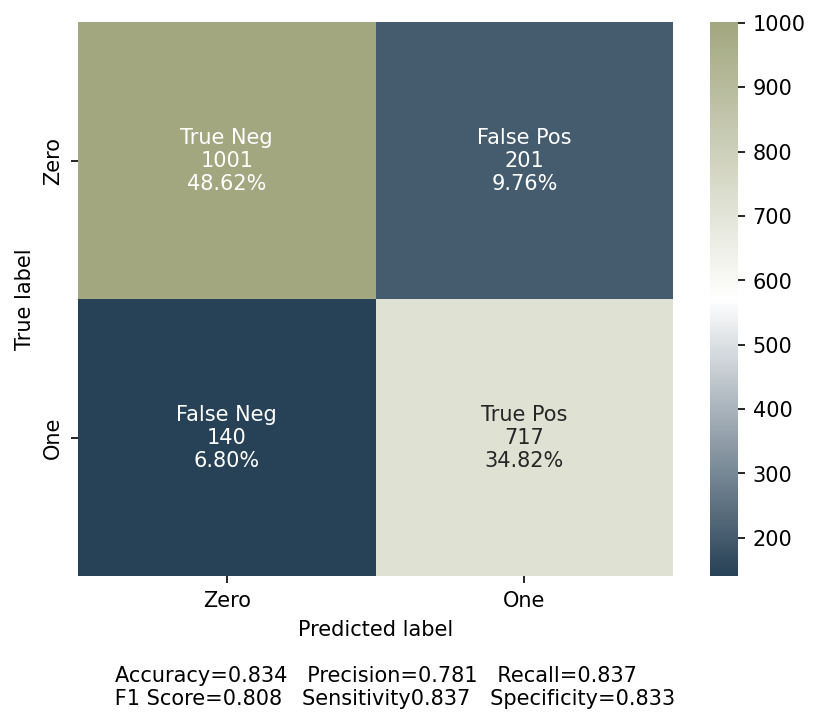

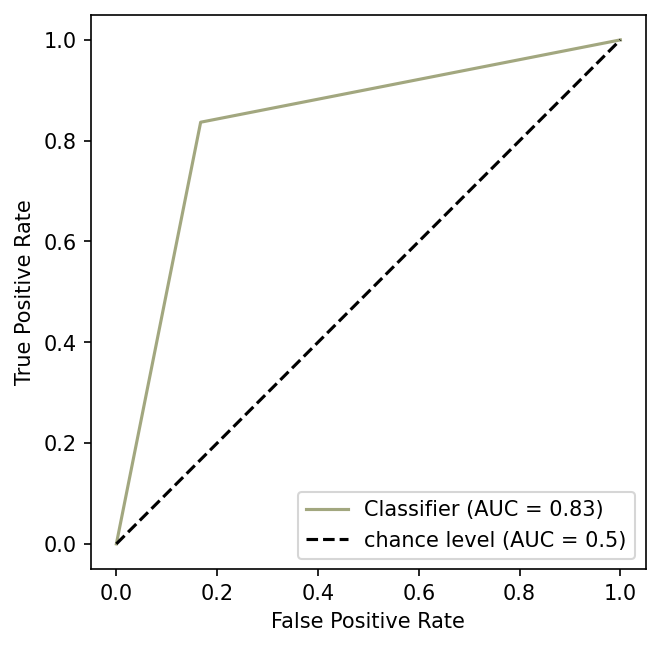

In [481]:

# create the Decision Tree model
dt = DecisionTreeClassifier(random_state=42)

# create the Bagging model with 100 base estimators
bagging = BaggingClassifier(dt, n_estimators=100, random_state=42)

# fit the model to the training data
bagging.fit(X_train, Y_train)

# make predictions on the testing data
y_pred = bagging.predict(X_valid)

make_confusion_matrix(confusion_matrix(Y_valid, y_pred), group_names=['True Neg','False Pos','False Neg','True Pos'],  categories=['Zero', 'One'], cmap=custom_cmap2)
plot_ROC(Y_valid, y_pred)


### Tuning

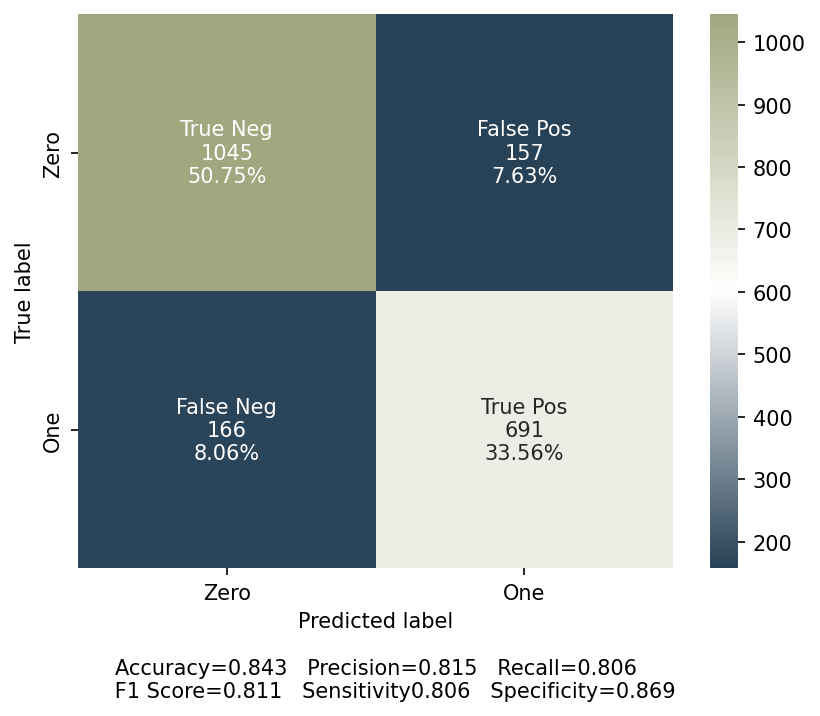

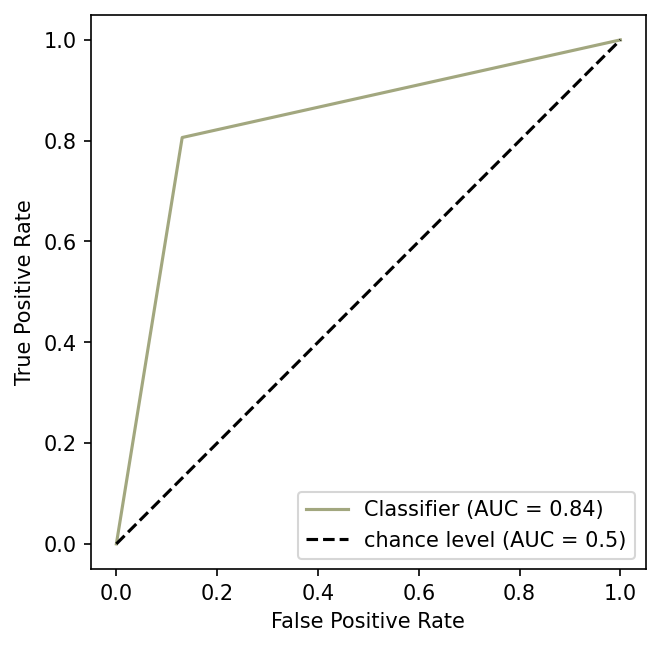

In [482]:
param_grid = {'n_estimators': [50, 100, 200],
              'max_samples': [0.5, 1.0],
              'bootstrap': [True, False],
              'bootstrap_features': [True, False]}

# create the GridSearchCV object
grid_search = GridSearchCV(BaggingClassifier(DecisionTreeClassifier(random_state=42), random_state=42),
                           param_grid, cv=5)

# fit the GridSearchCV object to the training data
grid_search.fit(X_train, Y_train)

# create a new Bagging model with the best hyperparameters found during the hyperparameter tuning process
bagging = BaggingClassifier(DecisionTreeClassifier(random_state=42),
                            n_estimators=grid_search.best_params_['n_estimators'],
                            max_samples=grid_search.best_params_['max_samples'],
                            bootstrap=grid_search.best_params_['bootstrap'],
                            bootstrap_features=grid_search.best_params_['bootstrap_features'],
                            random_state=42)

# fit the model to the entire training data
bagging.fit(X_train, Y_train)

y_pred = bagging.predict(X_valid)

make_confusion_matrix(confusion_matrix(Y_valid, y_pred), group_names=['True Neg','False Pos','False Neg','True Pos'],  categories=['Zero', 'One'], cmap=custom_cmap2)
plot_ROC(Y_valid, y_pred)


## Boosting Trees

In [483]:
from sklearn.ensemble import GradientBoostingClassifier

### No Tuning

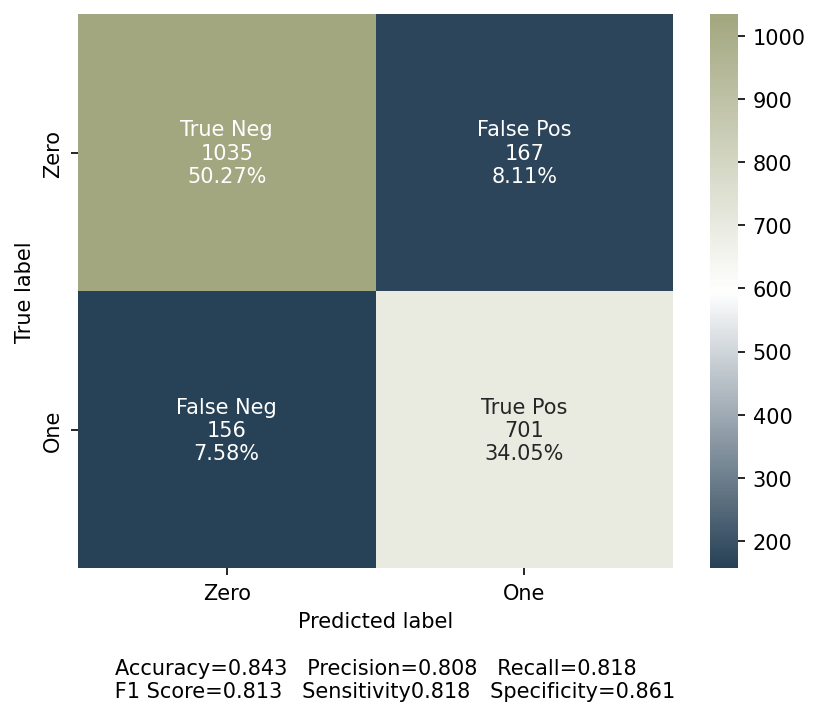

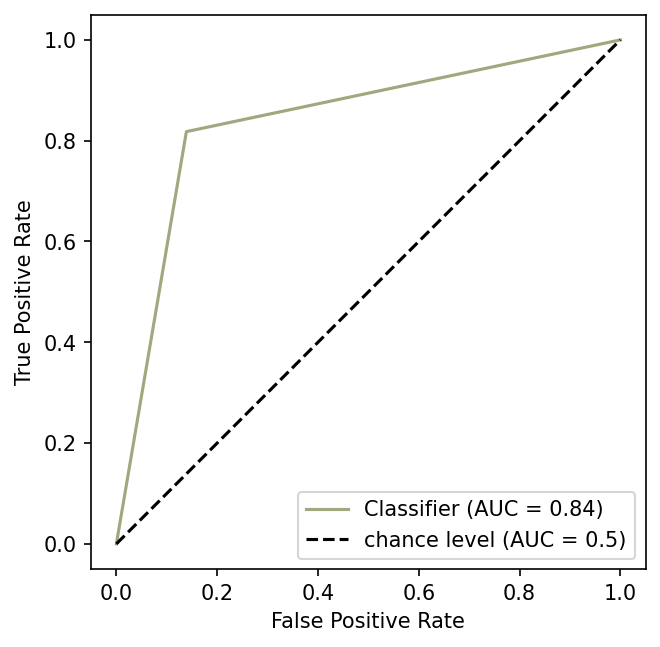

In [484]:
gb = GradientBoostingClassifier(random_state=42)

# fit the model to the training data
gb.fit(X_train, Y_train)

# make predictions on the testing data
y_pred = gb.predict(X_valid)

make_confusion_matrix(confusion_matrix(Y_valid, y_pred), group_names=['True Neg','False Pos','False Neg','True Pos'],  categories=['Zero', 'One'], cmap=custom_cmap2)
plot_ROC(Y_valid, y_pred)

### Tuning

Best hyperparameters:  {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 200, 'subsample': 1.0}


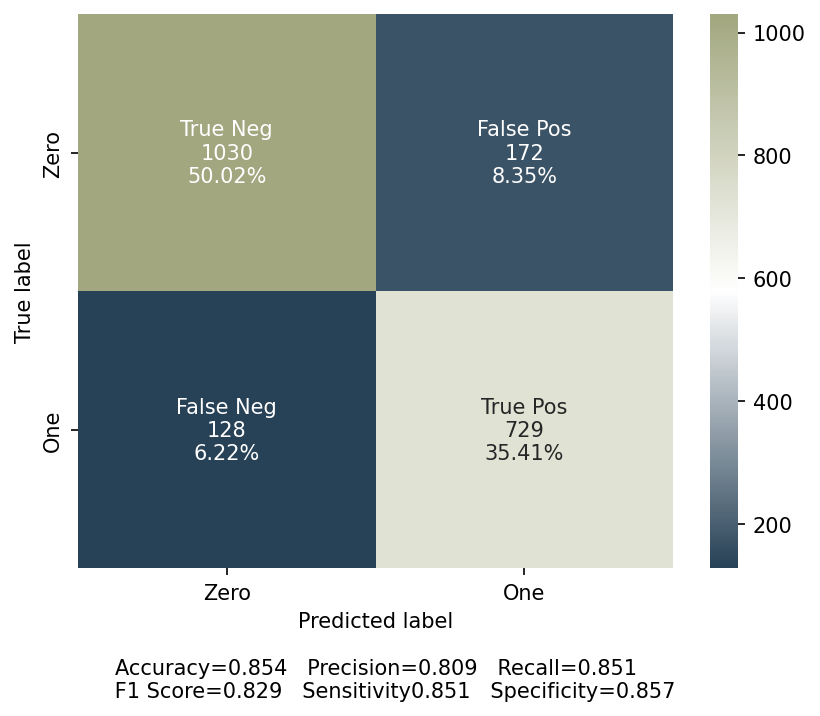

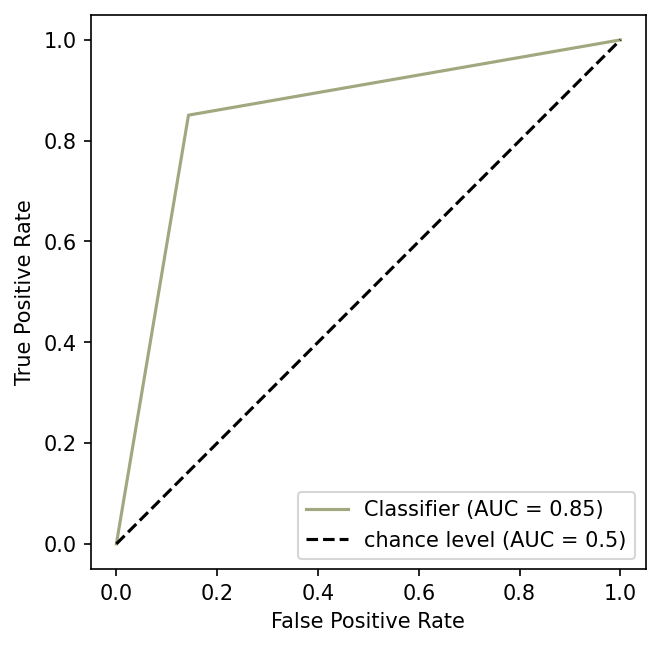

In [485]:
gb = GradientBoostingClassifier(random_state=42)

# set up the hyperparameter grid to search over
param_grid = {'n_estimators': [50, 100, 200],
              'learning_rate': [0.01, 0.1, 1.0],
              'max_depth': [2, 3, 4],
              'subsample': [0.5, 0.75, 1.0]}

# create the GridSearchCV object
grid_search = GridSearchCV(gb, param_grid, cv=5)

# fit the GridSearchCV object to the training data
grid_search.fit(X_train, Y_train)

# print the best hyperparameters found during the hyperparameter tuning process
print("Best hyperparameters: ", grid_search.best_params_)

# create a new Gradient Boosting model with the best hyperparameters found during the hyperparameter tuning process
gb = GradientBoostingClassifier(n_estimators=grid_search.best_params_['n_estimators'],
                                learning_rate=grid_search.best_params_['learning_rate'],
                                max_depth=grid_search.best_params_['max_depth'],
                                subsample=grid_search.best_params_['subsample'],
                                random_state=42)

# fit the model to the entire training data
gb.fit(X_train, Y_train)

# make predictions on the testing data
y_pred = gb.predict(X_valid)

make_confusion_matrix(confusion_matrix(Y_valid, y_pred), group_names=['True Neg','False Pos','False Neg','True Pos'],  categories=['Zero', 'One'], cmap=custom_cmap2)
plot_ROC(Y_valid, y_pred)

## Linear Discriminant Analysis (LDA)

In [486]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

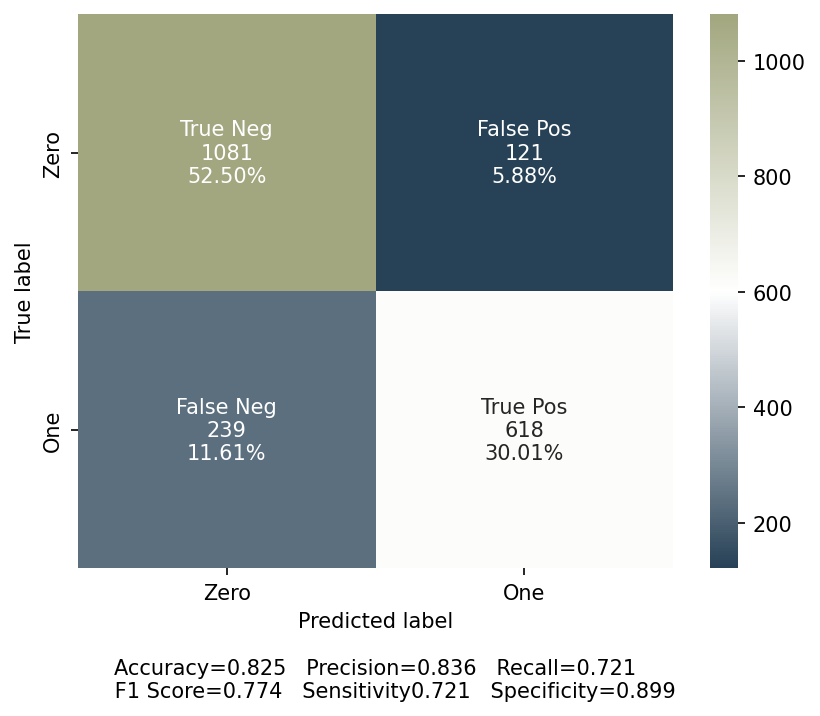

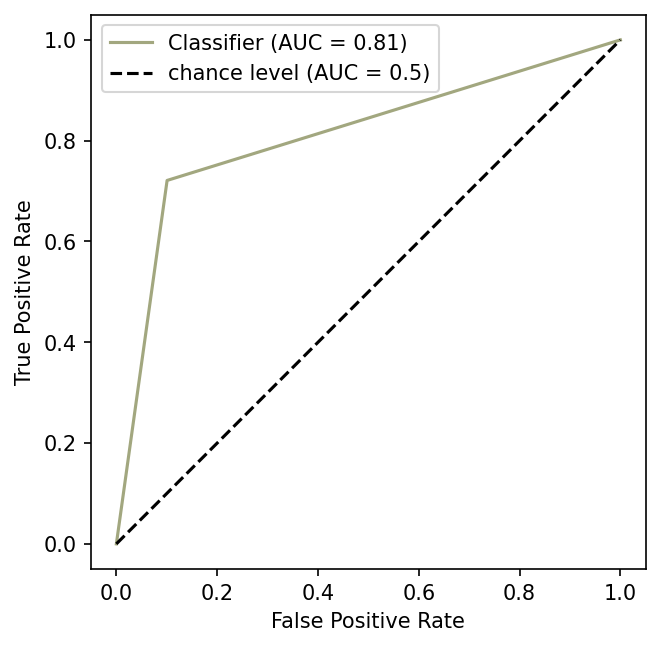

In [488]:
lda = LinearDiscriminantAnalysis()

# fit the LDA model to the training data
lda.fit(X_train, Y_train)

# make predictions on the testing data using the trained LDA model
y_pred = lda.predict(X_valid)

make_confusion_matrix(confusion_matrix(Y_valid, y_pred), group_names=['True Neg','False Pos','False Neg','True Pos'],  categories=['Zero', 'One'],cmap=custom_cmap2)
plot_ROC(Y_valid, y_pred)

## Support Vector Machines (SVM)

In [489]:
from sklearn import svm

### No Tuning

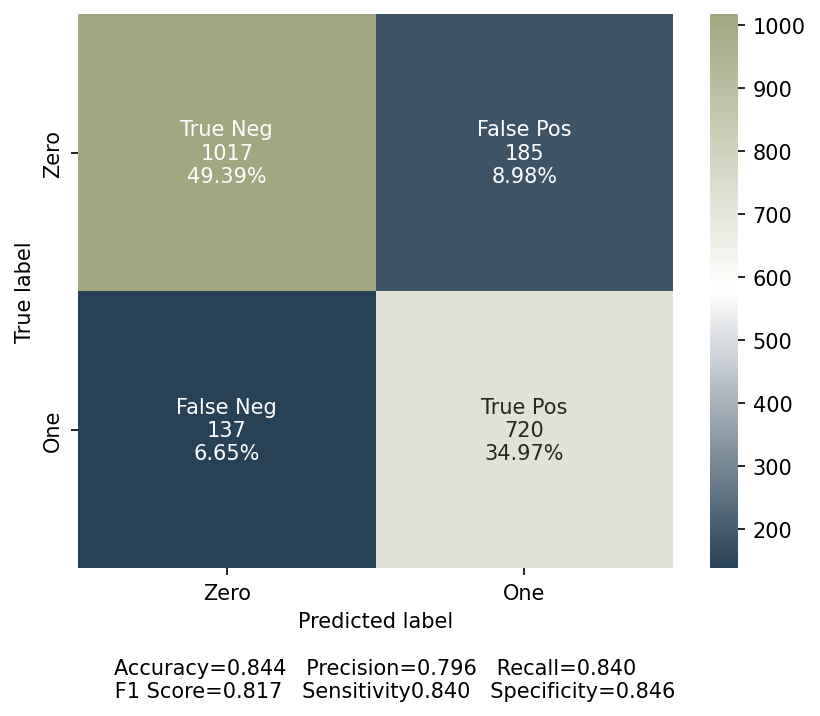

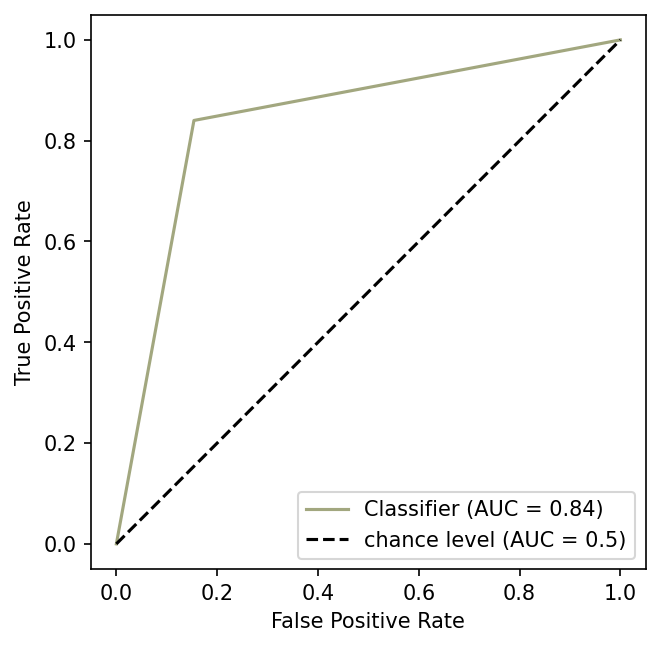

In [490]:
svm_model = svm.SVC()

# fit the SVM model to the training data
svm_model.fit(X_train, Y_train)

# make predictions on the testing data using the trained SVM model
y_pred = svm_model.predict(X_valid)

make_confusion_matrix(confusion_matrix(Y_valid, y_pred), group_names=['True Neg','False Pos','False Neg','True Pos'],  categories=['Zero', 'One'], cmap=custom_cmap2)
plot_ROC(Y_valid, y_pred)

### Tuning

Best hyperparameters:  {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}


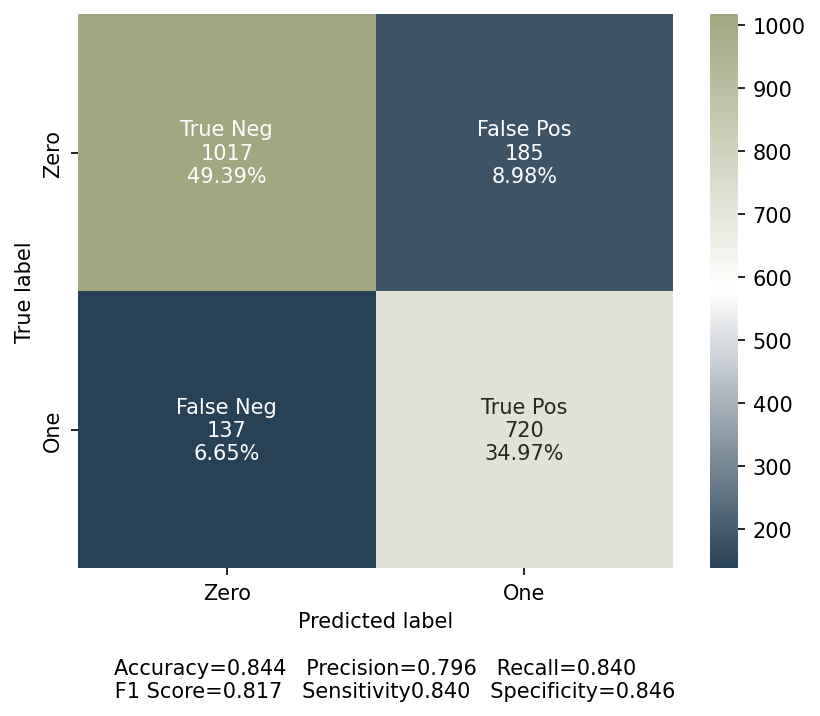

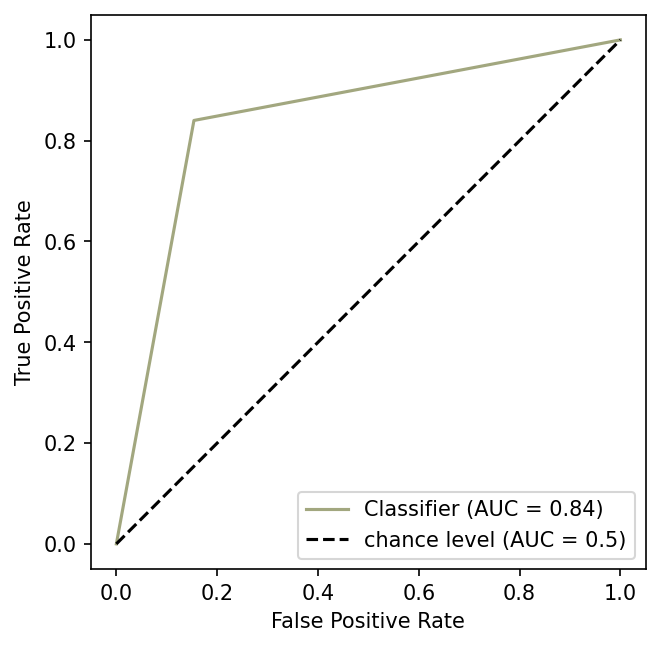

In [491]:
svm_model = svm.SVC()

# set up the hyperparameter grid to search over
param_grid = {'C': [0.1, 1, 10, 100],
              'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
              'gamma': ['scale', 'auto']}

# create the GridSearchCV object
grid_search = GridSearchCV(svm_model, param_grid, cv=5)

# fit the GridSearchCV object to the training data
grid_search.fit(X_train, Y_train)

# print the best hyperparameters found during the hyperparameter tuning process
print("Best hyperparameters: ", grid_search.best_params_)

# create a new SVM model with the best hyperparameters found during thehyperparameter tuning process
svm_model = svm.SVC(C=grid_search.best_params_['C'],
                    kernel=grid_search.best_params_['kernel'],
                    gamma=grid_search.best_params_['gamma'])

# fit the SVM model to the training data
svm_model.fit(X_train, Y_train)

# make predictions on the testing data using the trained SVM model
y_pred = svm_model.predict(X_valid)

make_confusion_matrix(confusion_matrix(Y_valid, y_pred), group_names=['True Neg','False Pos','False Neg','True Pos'],  categories=['Zero', 'One'], cmap=custom_cmap2)
plot_ROC(Y_valid, y_pred)

## XGBoost

In [501]:
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from matplotlib import pyplot

### No Tuning

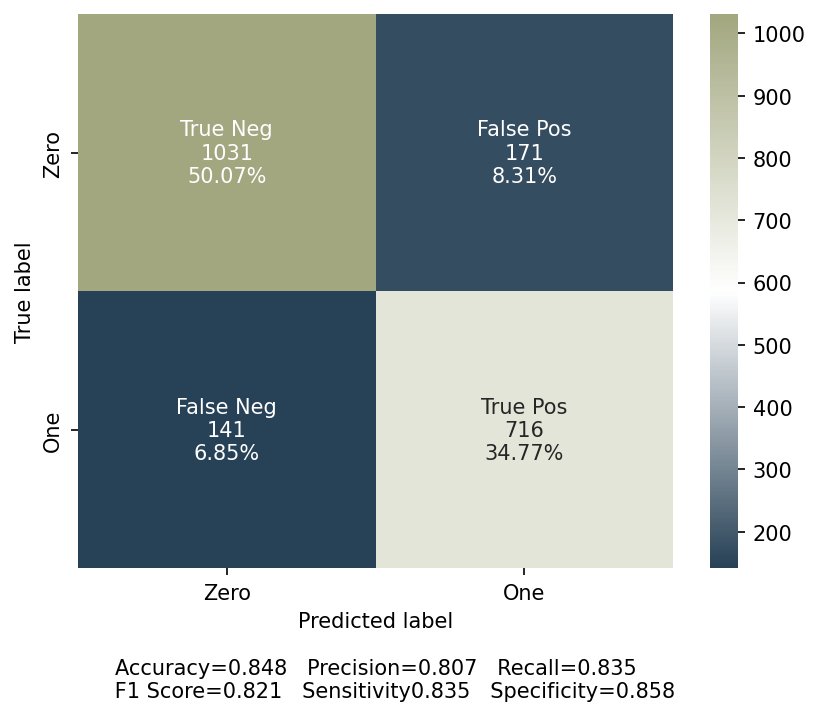

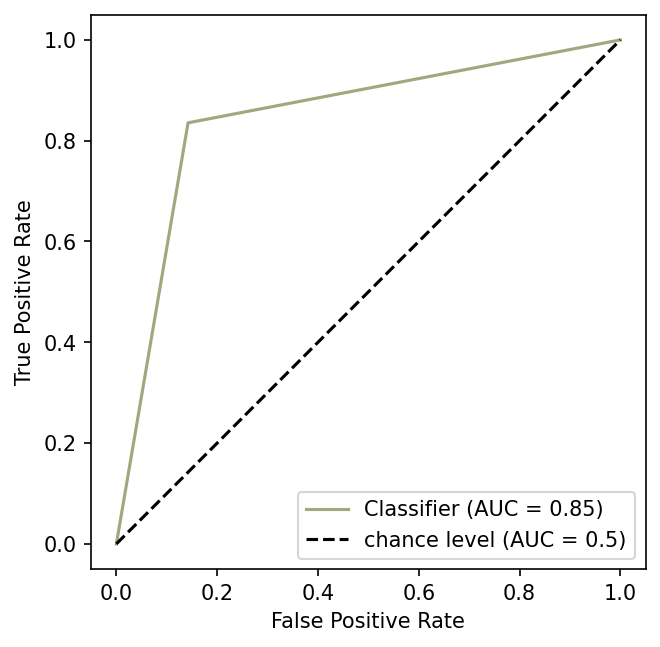

In [502]:
# Instantiate the XGBClassifier class
xg_clf = xgb.XGBClassifier(objective='binary:logistic', n_estimators=10, seed=123)

# Fit the model on the training data
xg_clf.fit(X_train, Y_train)

# Make predictions on the test data
y_pred = xg_clf.predict(X_valid)

make_confusion_matrix(confusion_matrix(Y_valid, y_pred), group_names=['True Neg','False Pos','False Neg','True Pos'],  categories=['Zero', 'One'], cmap=custom_cmap2)
plot_ROC(Y_valid, y_pred)


### Tuning

[0]	validation_0-error:0.17583	validation_0-logloss:0.56341	validation_1-error:0.18941	validation_1-logloss:0.57265
[1]	validation_0-error:0.15654	validation_0-logloss:0.49081	validation_1-error:0.17290	validation_1-logloss:0.50672
[2]	validation_0-error:0.14841	validation_0-logloss:0.43882	validation_1-error:0.17047	validation_1-logloss:0.46110
[3]	validation_0-error:0.14217	validation_0-logloss:0.40047	validation_1-error:0.16610	validation_1-logloss:0.42942
[4]	validation_0-error:0.13869	validation_0-logloss:0.37454	validation_1-error:0.15979	validation_1-logloss:0.40772
[5]	validation_0-error:0.13579	validation_0-logloss:0.35444	validation_1-error:0.15930	validation_1-logloss:0.39162
[6]	validation_0-error:0.13347	validation_0-logloss:0.33995	validation_1-error:0.15444	validation_1-logloss:0.38068
[7]	validation_0-error:0.13013	validation_0-logloss:0.32928	validation_1-error:0.15299	validation_1-logloss:0.37374
[8]	validation_0-error:0.12767	validation_0-logloss:0.32046	validation_1

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[15]	validation_0-error:0.11272	validation_0-logloss:0.27519	validation_1-error:0.14522	validation_1-logloss:0.34754
[16]	validation_0-error:0.11330	validation_0-logloss:0.27190	validation_1-error:0.14910	validation_1-logloss:0.34587
[17]	validation_0-error:0.11069	validation_0-logloss:0.26795	validation_1-error:0.14619	validation_1-logloss:0.34520
[18]	validation_0-error:0.11142	validation_0-logloss:0.26412	validation_1-error:0.14376	validation_1-logloss:0.34386
[19]	validation_0-error:0.11055	validation_0-logloss:0.25997	validation_1-error:0.14327	validation_1-logloss:0.34247
[20]	validation_0-error:0.10823	validation_0-logloss:0.25655	validation_1-error:0.14424	validation_1-logloss:0.34171
[21]	validation_0-error:0.10721	validation_0-logloss:0.25460	validation_1-error:0.14424	validation_1-logloss:0.34114
[22]	validation_0-error:0.10605	validation_0-logloss:0.25112	validation_1-error:0.14619	validation_1-logloss:0.34026
[23]	validation_0-error:0.10329	validation_0-logloss:0.24734	val

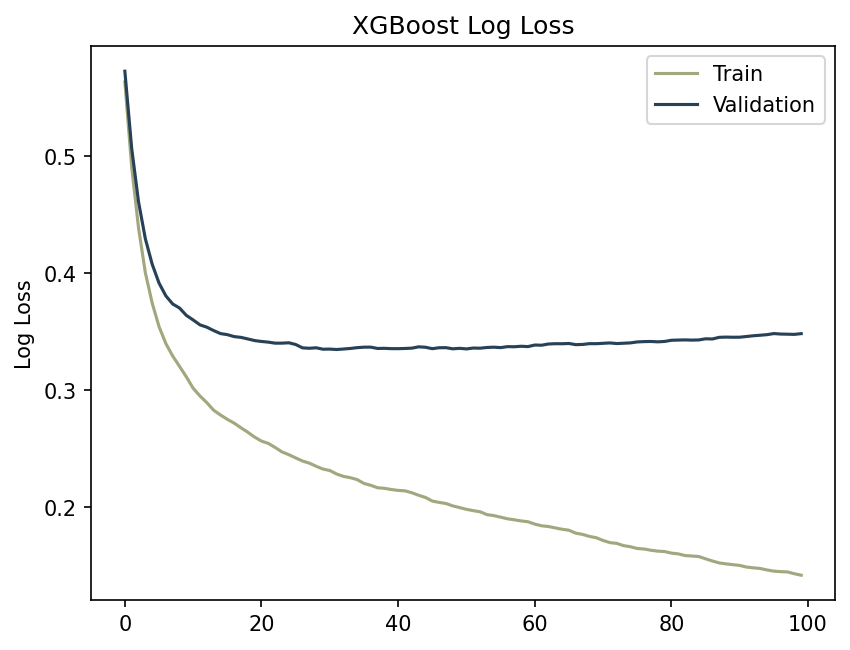

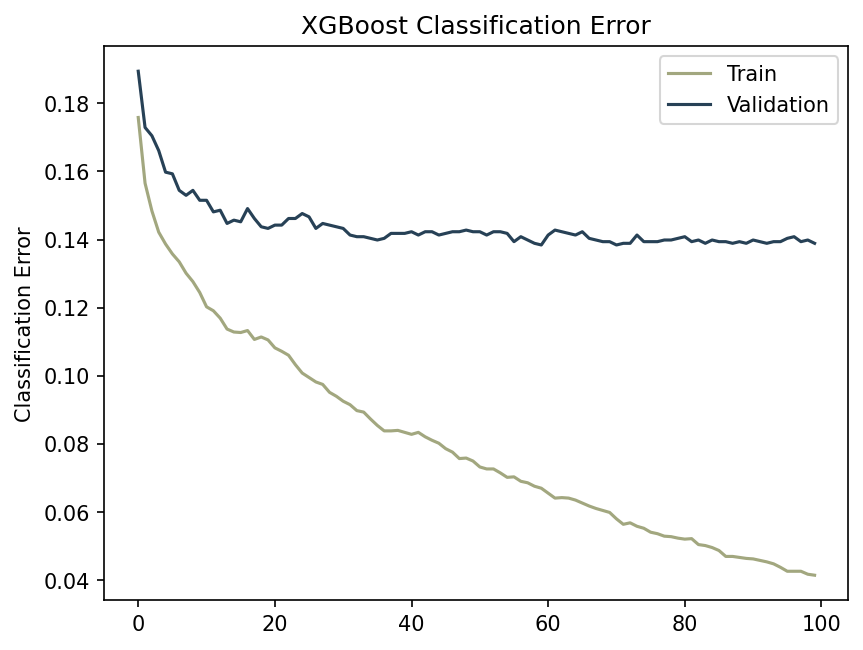

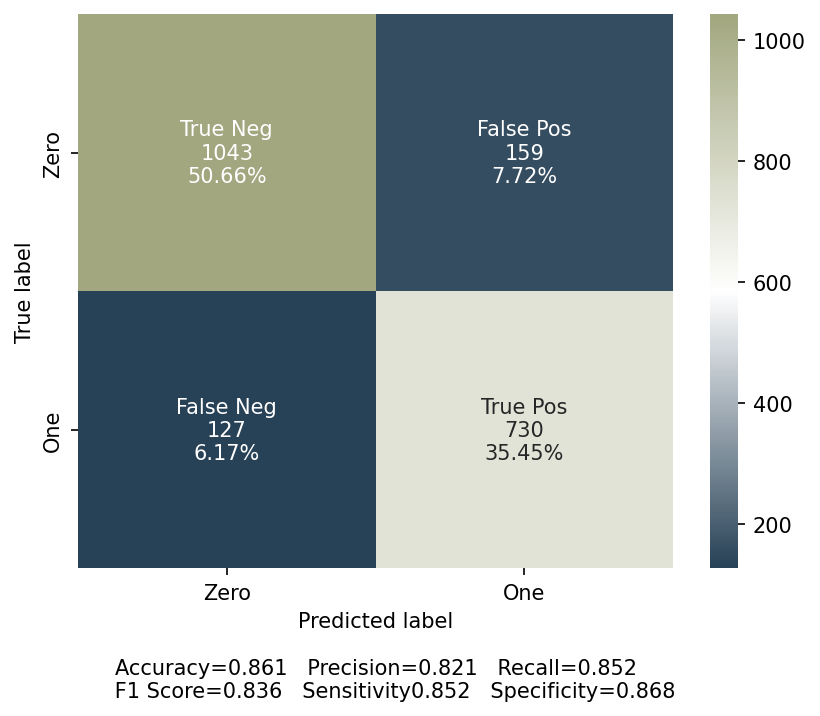

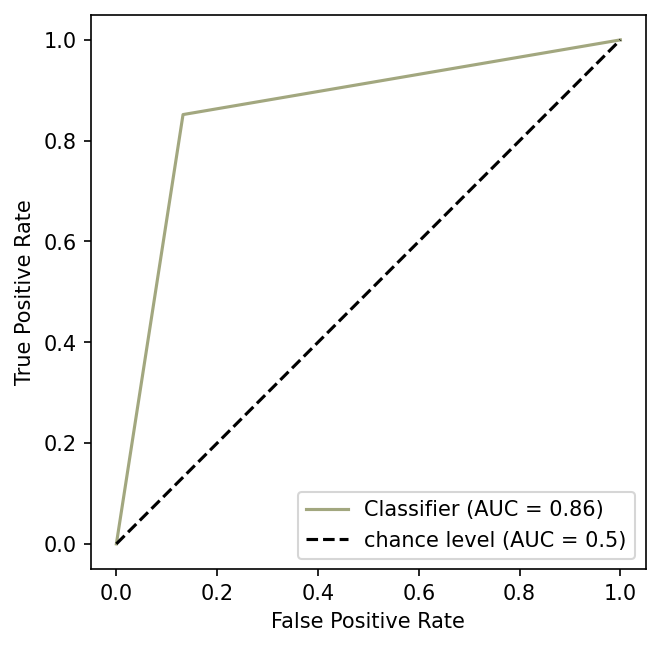

In [508]:

# fit model no training data
model = XGBClassifier()
eval_set = [(X_train, Y_train), (X_valid, Y_valid)]
model.fit(X_train, Y_train, eval_metric=["error", "logloss"], eval_set=eval_set, verbose=True)
# make predictions for test data
y_pred = model.predict(X_valid)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(Y_valid, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
# retrieve performance metrics
results = model.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], color=second_col,label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], color=main_col,label='Validation')
ax.legend()
pyplot.ylabel('Log Loss')
pyplot.title('XGBoost Log Loss')
pyplot.show()
# plot classification error
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['error'],color=second_col, label='Train')
ax.plot(x_axis, results['validation_1']['error'], color=main_col,label='Validation')
ax.legend()
pyplot.ylabel('Classification Error')
pyplot.title('XGBoost Classification Error')
pyplot.show()

make_confusion_matrix(confusion_matrix(Y_valid, y_pred), group_names=['True Neg','False Pos','False Neg','True Pos'],  categories=['Zero', 'One'], cmap=custom_cmap2)
plot_ROC(Y_valid, y_pred)

## LightGBM

In [504]:
import lightgbm as lgb
from lightgbm import LGBMClassifier
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV

### No Tuning

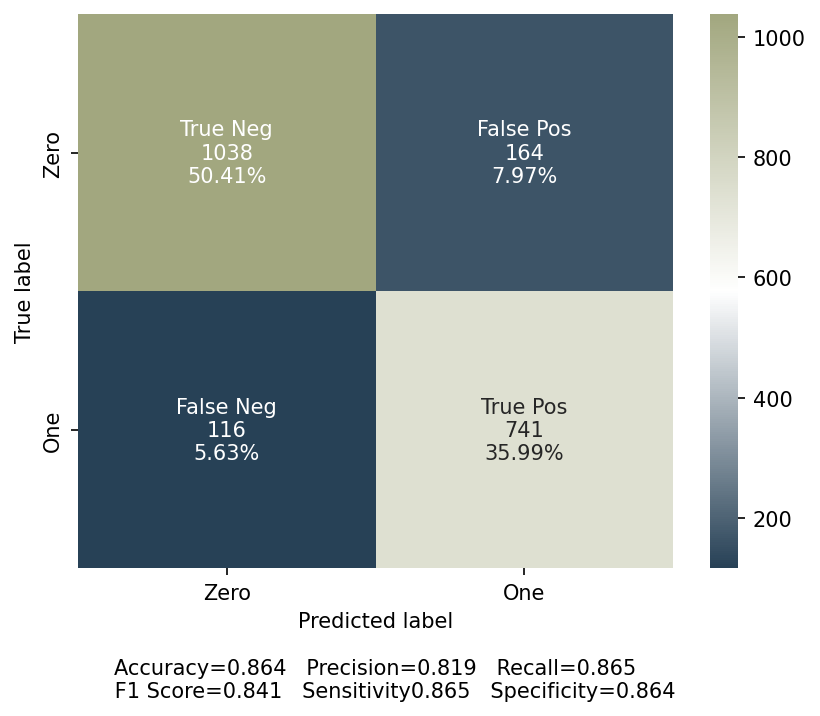

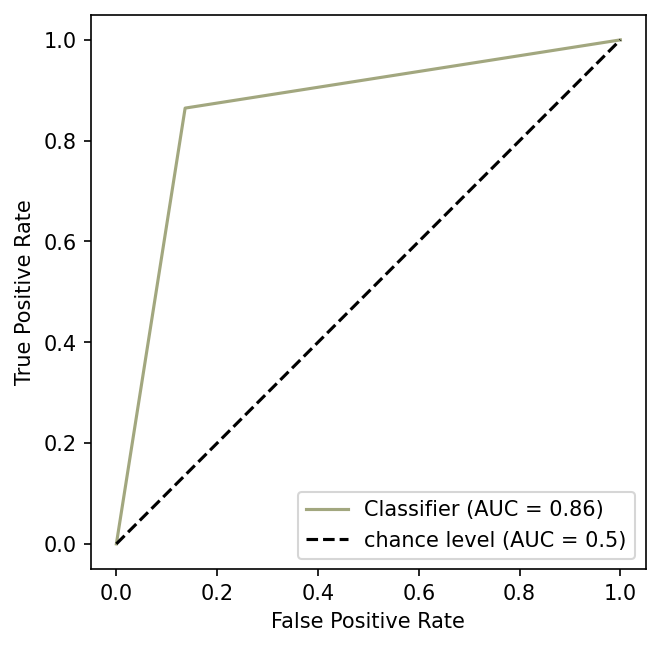

In [509]:
# create the LGBMClassifier model
lgb_model = LGBMClassifier()

# train the LGBMClassifier model using the training data
lgb_model.fit(X_train, Y_train)

# make predictions on the testing data using the trained LGBMClassifier model
y_pred = lgb_model.predict(X_valid)

make_confusion_matrix(confusion_matrix(Y_valid, y_pred), group_names=['True Neg','False Pos','False Neg','True Pos'],  categories=['Zero', 'One'], cmap=custom_cmap2)
plot_ROC(Y_valid, y_pred)

### Tuning

In [510]:
# Define the LightGBM model
model = lgb.LGBMClassifier(random_state=42)

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'num_leaves': [31, 63, 127],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.1, 0.01, 0.001],
    'reg_alpha': [0.1, 0.5, 1],
    'reg_lambda': [0.1, 0.5, 1],
    'min_child_samples': [20, 50, 100],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# Perform grid search cross-validation to find the best hyperparameters
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train, Y_train)

# Print the best hyperparameters and corresponding AUC score
print("Best hyperparameters:", grid_search.best_params_)
print("Best AUC score:", grid_search.best_score_)

# Evaluate the best model on the validation set
best_model = grid_search.best_estimator_
y_pred = best_model.predict_proba(X_valid)[:, 1]
y_pred = (y_pred > 0.5).astype(int)

make_confusion_matrix(confusion_matrix(Y_valid, y_pred), group_names=['True Neg','False Pos','False Neg','True Pos'],  categories=['Zero', 'One'], cmap=custom_cmap2)
plot_ROC(Y_valid, y_pred)

0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
19475.02s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
19475.06s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
19475.09s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
19475.12s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
19475.15s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
19475.17s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
19475.20s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
19475.23s - pydevd: Se

## CatBoost

In [ ]:
import catboost as cb
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostClassifier

### No Tuning

In [ ]:
model = cb.CatBoostClassifier(iterations=100, learning_rate=0.1, depth=6)
model.fit(X_train, Y_train)

y_pred = model.predict(X_valid)

make_confusion_matrix(confusion_matrix(Y_valid, y_pred), group_names=['True Neg','False Pos','False Neg','True Pos'],  categories=['Zero', 'One'], cmap=custom_cmap2)
plot_ROC(Y_valid, y_pred)

### Tuning

In [ ]:

clf = CatBoostClassifier(
    iterations=50,
    random_seed=42,
    learning_rate=0.5,
    custom_loss=['AUC', 'Accuracy']
)

clf.fit(
    X_train, Y_train,
    eval_set=(X_valid, Y_valid),
    verbose=False,
    plot=True
)

y_pred = clf.predict(X_valid)

make_confusion_matrix(confusion_matrix(Y_valid, y_pred), group_names=['True Neg','False Pos','False Neg','True Pos'],  categories=['Zero', 'One'], cmap=custom_cmap2)
plot_ROC(Y_valid, y_pred)

## Neural Network

### Tuning

# __Best Predictive Model__

# __Kaggle Competition__

## Best Predictive Model Fitited with 100% Train 

## Predictions